In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import arviz as az 
from RandomLoop import StateSpace, check_connectivity
import json, pickle
from scipy.optimize import curve_fit

In [2]:
plt.style.use('default')
plt.style.use('seaborn-v0_8-muted')

# Convergence and Equilibrium

### Fast and Slow

In [4]:
m = StateSpace(3, 64, 2) 

obs = {
    'mean_links' : m.mean_links, 
    'mean_loop_length' : m.mean_loop_length, 
    }


def longest_loop(grid):
    _, lengths = m.loop_builder()
    lengths_merged = [l for sublist in lengths for l in sublist]
    return np.max(lengths_merged)
    

def connectivity(grid, d, grid_size):
    # get M random pairs at ditance d
    x_vertices = [tuple(np.random.randint(1, grid_size + 1, 2)) for _ in range(1000)]
    y_vertices = []
    for x in x_vertices:
        if x[0] + d >= grid_size:
            y_vertices.append(  (x[0] - d, x[1]) )
        else:
            y_vertices.append(  (x[0] + d, x[1]) )
    tot = 0
    for i in range(1000):
        tot += check_connectivity(m.grid, 0, x_vertices[i], y_vertices[i])
        
    return tot / 1000

m.step(2_000_000, 10_000, observables=obs)

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [30]:
step = range(0, 2_000_000, 10_000)

ob1 = np.mean(m.data['mean_links'], axis=1)
ob1_avg = np.mean(m.data['mean_links'][-100:])

ob2 = np.array(m.data['mean_loop_length'])
ob2_avg = np.mean(m.data['mean_loop_length'][-100:])

plt.scatter(step, ob1 / ob1_avg, s=4, label='mean links')
plt.scatter(step, ob2 / ob2_avg, s=4, label='mean loop length')

plt.title(r'L = 64    $\beta$ = 2')
plt.xlabel(r'steps ($10^3$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, markerscale=4)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}'))
plt.savefig('short_time_obs.pdf')

KeyError: 'mean_loop_length'

In [19]:
#m = StateSpace(3, 64, 2) 

obs = {
    'longest_loop' : lambda: longest_loop(m.grid),
    'connectivity' : lambda: connectivity(m.grid, 8, 64)
    }


def longest_loop(grid):
    _, lengths = m.loop_builder()
    lengths_merged = [l for sublist in lengths for l in sublist]
    return np.max(lengths_merged)
    

def connectivity(grid, d, grid_size):
    # get M random pairs at ditance d
    x_vertices = [tuple(np.random.randint(1, grid_size + 1, 2)) for _ in range(1000)]
    y_vertices = []
    for x in x_vertices:
        if x[0] + d >= grid_size:
            y_vertices.append(  (x[0] - d, x[1]) )
        else:
            y_vertices.append(  (x[0] + d, x[1]) )
    tot = 0
    for i in range(1000):
        tot += check_connectivity(m.grid, 0, x_vertices[i], y_vertices[i])
        
    return tot / 1000

m.step(20_000_000, 20_000, observables=obs)

  0%|          | 0/20000000 [00:00<?, ?it/s]

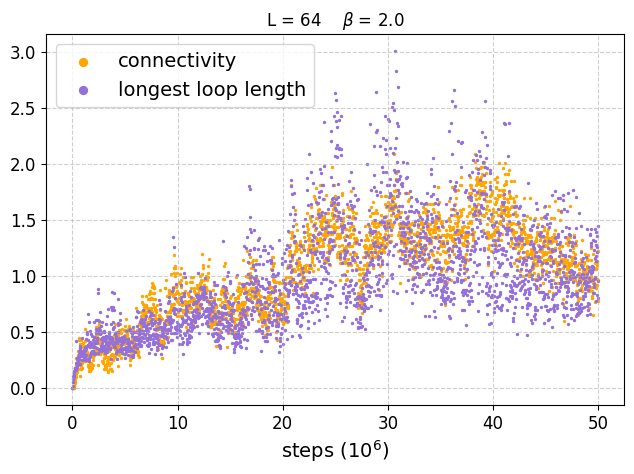

In [20]:
step = range(0, 50_000_000, 20_000)

ob3 = np.array(m.data['connectivity'])
ob3_avg = np.mean(m.data['connectivity'][-100:])

ob4 = np.array(m.data['longest_loop'])
ob4_avg = np.mean(m.data['longest_loop'][-100:])


plt.scatter(step, ob3 / ob3_avg, s=2, label='connectivity', c='orange' )
plt.scatter(step, ob4 / ob4_avg, s=2, label='longest loop length', c='mediumpurple')
plt.title(r'L = 64    $\beta$ = 2.0')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, markerscale=4)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.savefig('long_time_obs.pdf')

### $L^2$ dependence

In [21]:
sizes = [64, 96, 128, 256]
data = []
for L in sizes:

    m = StateSpace(3, L, 2) 
    obs = {
        'mean_links' : m.mean_links, 
        }

    m.step(10_000_000, 10_000, observables=obs)
    data.append( np.mean(m.data['mean_links'], axis=1) )

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

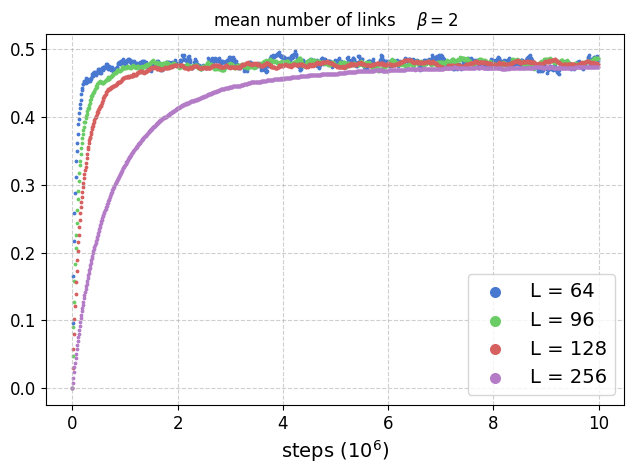

In [27]:
for i,L in enumerate(sizes):
    plt.scatter(range(0, 10_000_000, 10_000), data[i][:1000], s=3, label=f'{L = }')

plt.title(r'mean number of links    $\beta = 2$')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, markerscale=4)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.savefig('mean_links_vs_L.pdf')


In [ ]:
64 

In [110]:
for L in sizes:
    T = 0.5 * (L/64)**2
    print(T/10)

0.05
0.1125
0.2
0.8


## $\beta$ dependence

In [169]:
betas = np.arange(1, 5)
data = []
for beta in betas:

    m = StateSpace(3, 64, beta) 
    obs = {
        'longest_loop': lambda: longest_loop(m)
        }

    m.step(100_000_000, 500_000, observables=obs)
    data.append( m.data['longest_loop'] )

  0%|          | 0/100000000 [00:00<?, ?it/s]

  0%|          | 0/100000000 [00:00<?, ?it/s]

  0%|          | 0/100000000 [00:00<?, ?it/s]

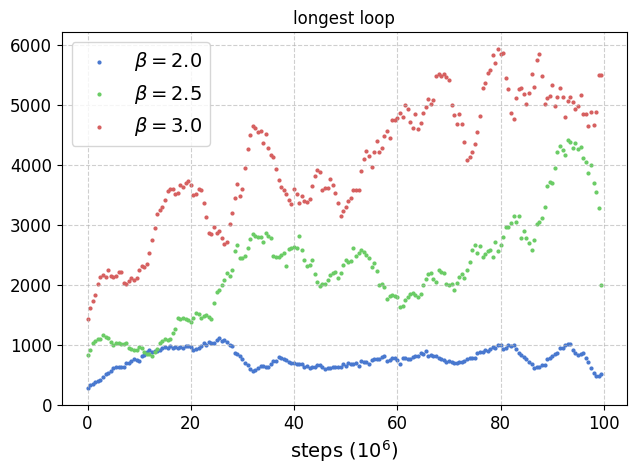

In [173]:
# normalize data 

#data_norm = [  np.array(d) / np.mean(d[-100:]) for d in data ]

def smoother(data, s=10):
    smooth_data = [ np.mean(data[i:i+s]) for i in range(len(data))  ]
    return smooth_data

for i,beta in enumerate(betas):
    plt.scatter(range(0, 100_000_000, 500_000), smoother(data[i]), s=4, label= r'$\beta = $' + f'{beta}')

plt.title('longest loop')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
#plt.savefig('mean_links_vs_L.pdf')

In [174]:
betas = np.arange(2, 3.5, 0.5)
data_rand = []
for beta in betas:

    m2 = StateSpace(3, 64, beta, init='random') 
    obs = {
        'longest_loop': lambda: longest_loop(m2)
        }

    m2.step(100_000_000, 500_000, observables=obs)
    data_rand.append( m2.data['longest_loop'] )

  0%|          | 0/100000000 [00:00<?, ?it/s]

  0%|          | 0/100000000 [00:00<?, ?it/s]

  0%|          | 0/100000000 [00:00<?, ?it/s]

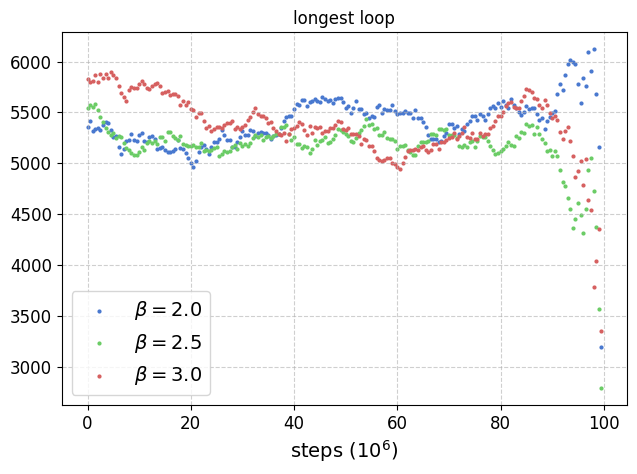

In [179]:
# normalize data 

#data_norm = [  np.array(d) / np.mean(d[-100:]) for d in data ]

for i,beta in enumerate(betas):
    plt.scatter(range(0, 100_000_000, 500_000), smoother(data_rand[i], s=50), s=4, label= r'$\beta = $' + f'{beta}')

plt.title('longest loop')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))

In [5]:
import json 

with open(r'C:\Users\lollo\Documents\Università\Thesis\Code\data\\random_init_test_2024-05-20_12_06_10.json', 'r') as file:
    data = np.array(json.load(file)['data'])


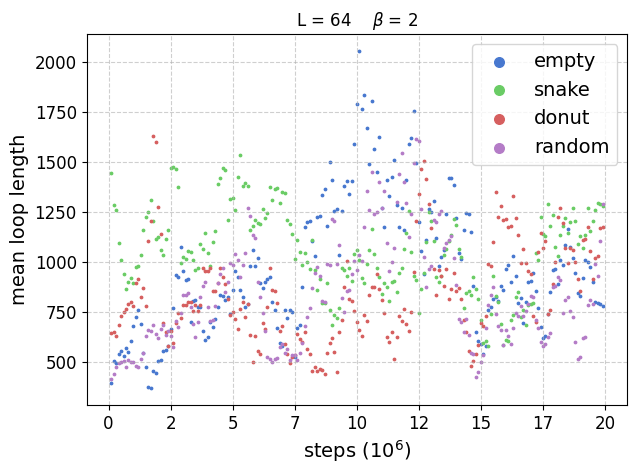

In [7]:
def smoother(data, s=4):
    smooth_data = [ np.mean(data[i:i+s]) for i in range(len(data))  ]
    return smooth_data

labels = ['empty', 'snake', 'donut', 'random']


for i,chain in enumerate(data):  # (chain, 1, 3, lens) 
   plt.scatter(range(100_000, 20_000_000, 100_000), smoother(chain[0][1:]), s=3, label=labels[i])


plt.title(r'L = 64    $\beta$ = 2')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.ylabel('mean loop length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, markerscale=4)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.savefig('diff_inits.pdf')

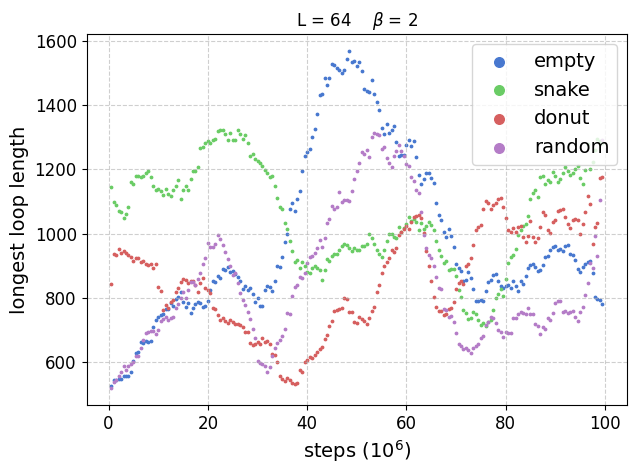

In [20]:
with open(r'C:\Users\lollo\Documents\Università\Thesis\Code\data\\random_init_test_2024-05-20_13_02_41.json', 'r') as file:
    data = np.array(json.load(file)['data'])

labels = ['empty', 'snake', 'donut', 'random']


for i,chain in enumerate(data):  # (chain, 1, 3, lens) 
   plt.scatter(range(500_000, 100_000_000, 500_000), smoother(chain[0], s=20)[1:], s=3, label=labels[i])


plt.title(r'L = 64    $\beta$ = 2')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.ylabel('longest loop length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, markerscale=4)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))

plt.savefig('diff_inits_longest_loop.pdf')

In [28]:
data2 = [d[0][20:] for d in data]

data_array = np.array(data2)

idata = az.convert_to_inference_data(data_array)

In [117]:
idata

Inference data with groups:
	> posterior

In [123]:
with open(r'C:\Users\lollo\Documents\Università\Thesis\Code\data\\random_init_test_2024-05-20_18_09_57.json', 'r') as file:
    data = np.array(json.load(file)['data'])

data_array = np.transpose( np.array(data), (0, 2, 1, 3))


data = {
    'mean_loop_length': data_array[:, :, :, 1],
    'longest_loop_length': data_array[:, :, :, 0]
    
}

coords = {
    'beta': [2, 3, 4] #, 192, 256]
}
dims = {
    'mean_loop_length': ['beta'],
    'longest_loop_length' : ['beta']
}

idata = az.convert_to_inference_data(data, dims=dims, coords=coords)

az.summary(idata)

ValueError: axes don't match array

C:\Users\lollo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\plots\backends\matplotlib\traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


array([[<Axes: title={'center': 'mean_loop_length'}>,
        <Axes: title={'center': 'mean_loop_length'}>],
       [<Axes: title={'center': 'longest_loop_length'}>,
        <Axes: title={'center': 'longest_loop_length'}>]], dtype=object)

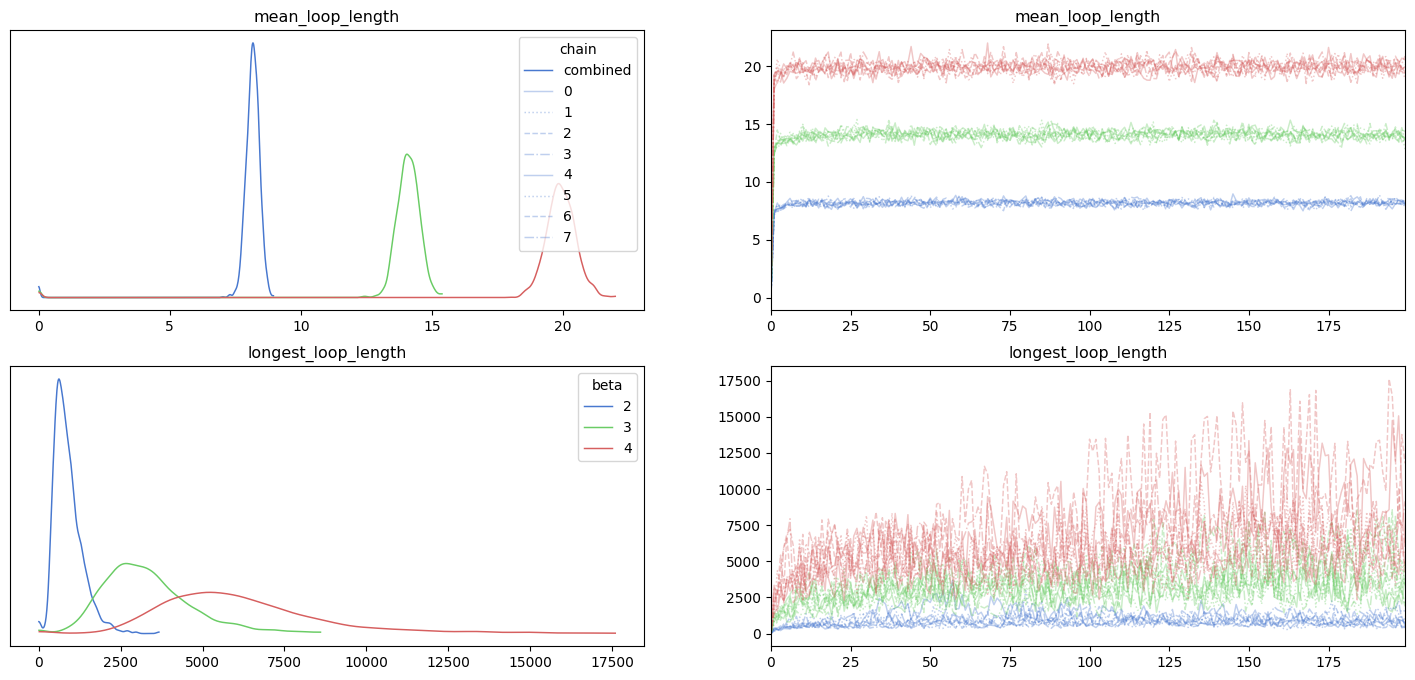

In [118]:
az.plot_trace(idata, legend=True, figsize=(18,8), kind="trace", combined=True)

In [114]:
dd = np.transpose(data['longest_loop_length'], (1, 0, 2))
dd.shape

(200, 8, 3)

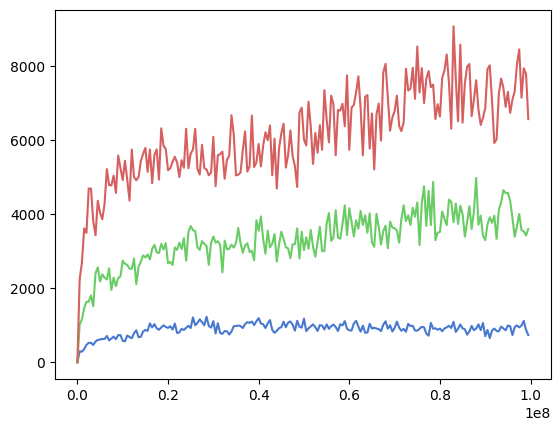

In [122]:

data_avg = [np.mean(d, axis=0) for d in dd] 

plt.plot( np.array( [range(0, 100_000_000, 500_000)]*3).T , data_avg)
        


In [125]:
data.shape

(8, 3, 100)

In [126]:


with open(r'C:\Users\lollo\Documents\Università\Thesis\Code\data\\random_init_test_2024-05-20_19_34_20.json', 'r') as file:
    data = np.array(json.load(file)['data'])

data_array = np.transpose( np.array(data), (0, 2, 1))


data = {
    'connectivity': data_array,
}

coords = {
    'beta': [2, 3, 4] #, 192, 256]
}
dims = {
    'connectivity': ['beta'],
}

idata = az.convert_to_inference_data(data, dims=dims, coords=coords)

az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
connectivity[2]  0.035  0.021   0.000    0.071      0.005    0.004      15.0   
connectivity[3]  0.121  0.063   0.000    0.243      0.019    0.014      12.0   
connectivity[4]  0.216  0.070   0.096    0.351      0.020    0.015      12.0   

                 ess_tail  r_hat  
connectivity[2]      35.0   1.55  
connectivity[3]      22.0   1.96  
connectivity[4]      17.0   1.96

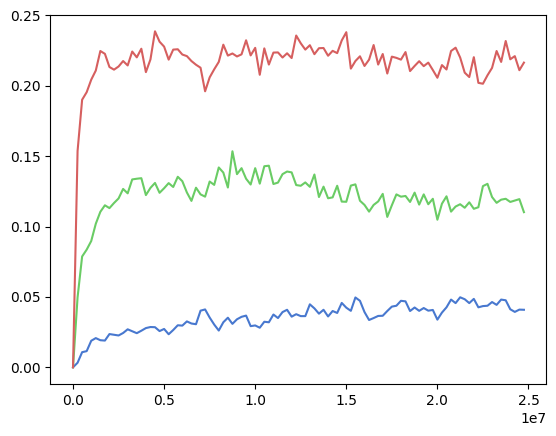

In [129]:
dd = np.transpose(data_array, (1, 0, 2))

data_avg = [np.mean(d, axis=0) for d in dd] 

plt.plot( np.array( [range(0, 25_000_000, 250_000)]*3).T , data_avg)
        

In [2]:
plt.style.use('default')
plt.style.use('seaborn-v0_8-muted')

In [3]:
m = StateSpace(3, 64, 2)
m.step(10_000_000)

  0%|          | 0/10000000 [00:00<?, ?it/s]

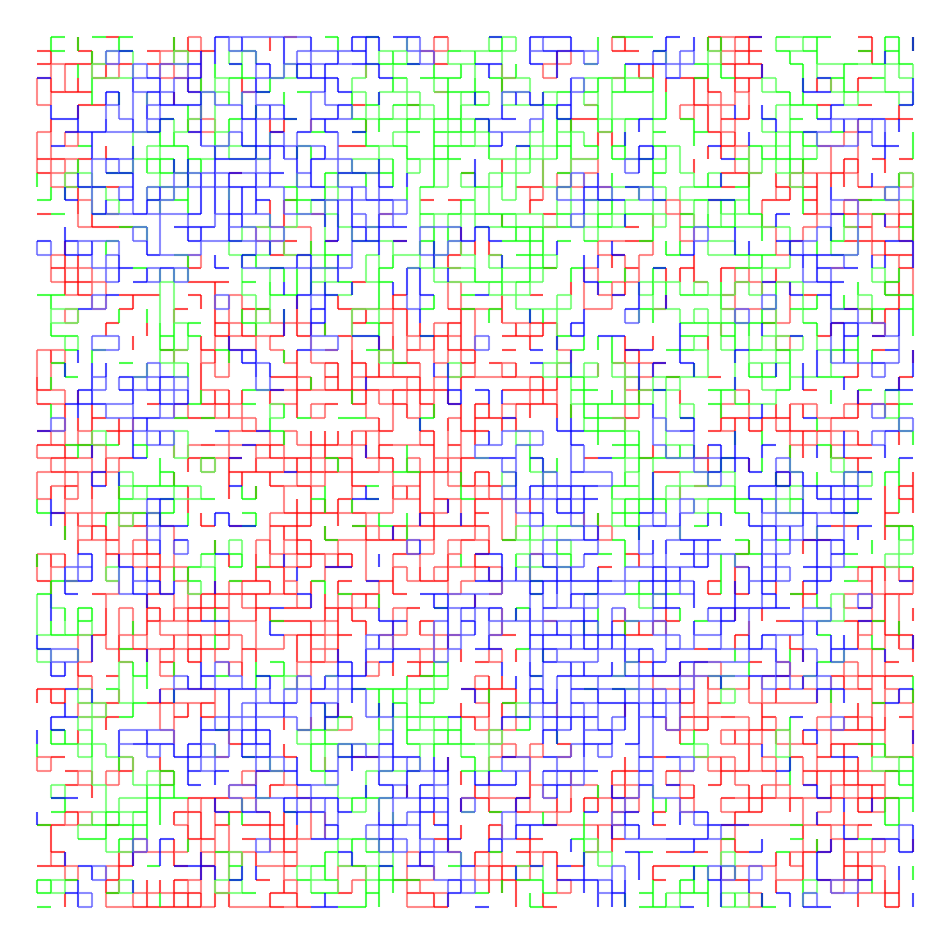

In [4]:
m.plot_overlap(linewidth=1.5, normalized=False, title='')

In [5]:
sum(m.mean_links())

1.47607421875

# Links

In [31]:

with open(r'data/links/links_2_64_2024-06-17_12_33_10.json', 'r') as file:
    data = np.array(json.load(file)['data'])

data_perm = np.transpose(data, (0, 2, 1, 3))

data_perm.shape

(8, 1000, 4, 2)

2.511999995088312 +/- 0.12823026133668028  -1.6311999945971434 +/- 0.1439381118103084
1.047452229196617


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

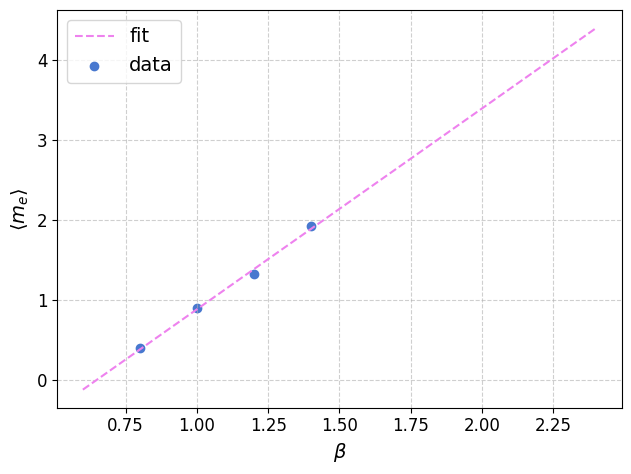

In [32]:
data = {
    'mean_links': np.sum(data_perm, axis=3), # sum over colors 
}

coords = {
    'beta': [0.8, 1.0, 1.2, 1.4]
}
dims = {
    'mean_links': ['beta'],
}

idata = az.convert_to_inference_data(data, dims=dims, coords=coords)

summary = az.summary(idata)

def linear(x, a, b):
    return a*x + b 

x = [0.8, 1.0, 1.2, 1.4]
y = summary['mean'].values

p, pcov = curve_fit(linear, x, y)
print(f'{p[0]} +/- {np.sqrt(pcov[0,0])}  {p[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'{(1 - p[1]) / p[0]}')
plt.plot(np.linspace(0.6, 2.4, 50), linear(np.linspace(0.6, 2.4, 50), p[0], p[1]), '--', color='violet', label='fit')
plt.scatter(x, y, label='data')

plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'$\langle m_e \rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, markerscale=1)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


In [57]:
data = {
    'mean_links': np.sum(data_perm, axis=3), # sum over colors 
}

coords = {
    'beta': range(1, 9)
}
dims = {
    'mean_links': ['beta'],
}

idata = az.convert_to_inference_data(data, dims=dims, coords=coords)

summary = az.summary(idata)
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mean_links[1]  0.380  0.010   0.360    0.399      0.001    0.000     221.0   
mean_links[2]  1.441  0.016   1.411    1.470      0.001    0.001     189.0   
mean_links[3]  2.464  0.018   2.430    2.499      0.001    0.001     405.0   
mean_links[4]  3.476  0.021   3.435    3.516      0.001    0.001     215.0   
mean_links[5]  4.480  0.025   4.435    4.528      0.002    0.001     142.0   
mean_links[6]  5.481  0.027   5.432    5.533      0.002    0.001     190.0   
mean_links[7]  6.482  0.029   6.425    6.533      0.002    0.001     257.0   
mean_links[8]  7.486  0.033   7.424    7.548      0.003    0.002     116.0   

               ess_tail  r_hat  
mean_links[1]     447.0   1.02  
mean_links[2]     483.0   1.04  
mean_links[3]     747.0   1.02  
mean_links[4]     559.0   1.04  
mean_links[5]     302.0   1.05  
mean_links[6]     639.0   1.05  
mean_links[7]     622.0   1.02  
mean_links[8]     447.0   1.05

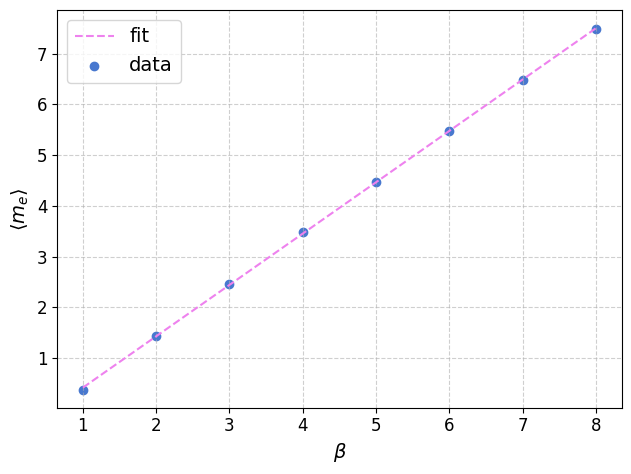

In [58]:
def linear(x, a, b):
    return a*x + b 

x = list(range(1,9))
y = summary['mean'].values

p, pcov = curve_fit(linear, x, y)

plt.plot(np.linspace(1, 8, 50), linear(np.linspace(1, 8, 50), p[0], p[1]), '--', color='violet', label='fit')
plt.scatter(x, y, label='data')

plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'$\langle m_e \rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, markerscale=1)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('mean_links_vs_beta.pdf')

In [106]:
m = StateSpace(2, 64, 1.1)

def diff():
    ml = m.mean_links()
    return np.abs(  ml[0] - ml[1]  ) / np.mean(ml)

obs = {
    'diff': diff
}

m.step(100_000_000, 10_000, observables=obs) 

  0%|          | 0/100000000 [00:00<?, ?it/s]

C:\Users\lollo\AppData\Local\Temp\ipykernel_11328\3572893615.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(  ml[0] - ml[1]  ) / np.mean(ml)


0.1890737547421753

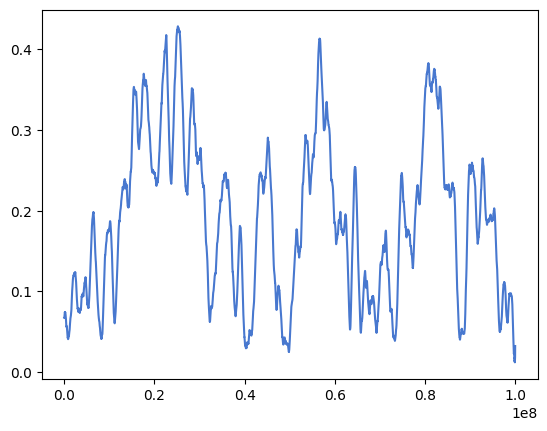

In [108]:
def smoother(data, w=100):
    smoothed = []
    for i in range(len(data)):
        smoothed.append(np.mean(data[i:i+w]))
    return smoothed

x = np.arange(10_000, 100_000_000, 10_000)
plt.plot(x, smoother(m.data['diff'][1:]))
np.mean(m.data['diff'][1:])

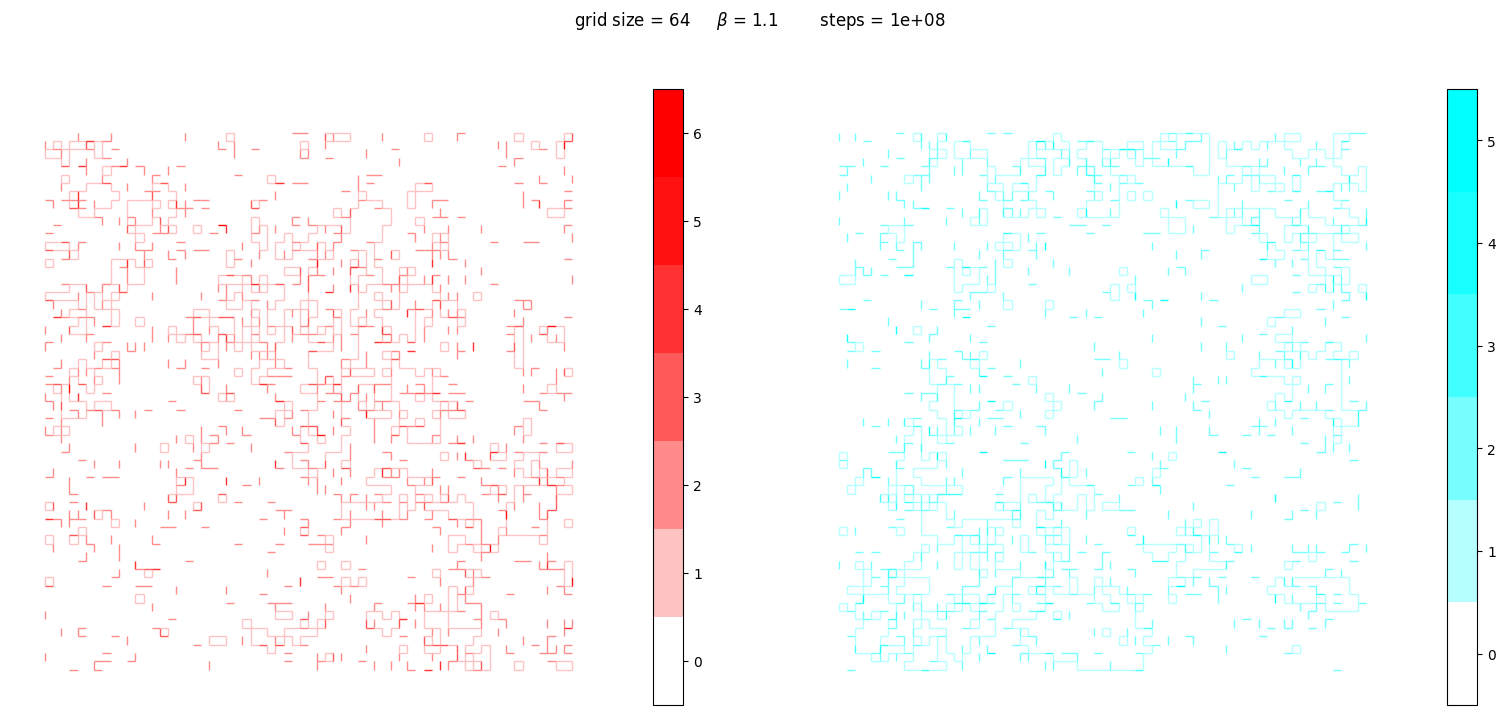

mean number of links: [0.40722656 0.37426758]
max number of links: [6 5]
mean local time: 1.600655076845553


ValueError: too many values to unpack (expected 2)

In [110]:
m.plot_grid()
m.summary()

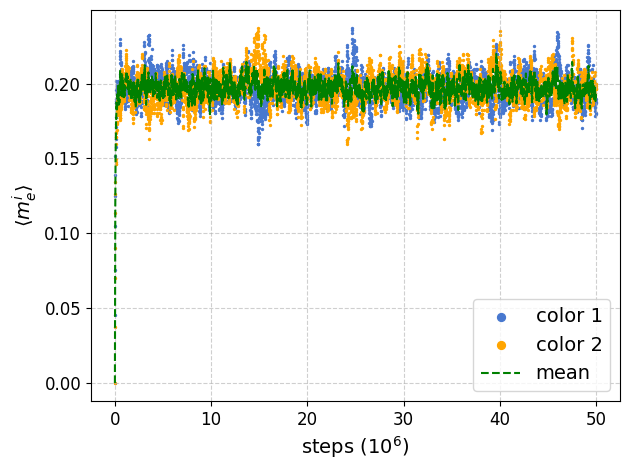

In [93]:
avg = np.mean(m.data['mean_links'], axis=1)
col1 = np.array(m.data['mean_links']).T[0]
col2 = np.array(m.data['mean_links']).T[1]

x = np.arange(0, 50_000_000, 10_000)

plt.scatter(x, col1, s=2, label='color 1')
plt.scatter(x, col2, s=2, c='orange', label='color 2')
plt.plot(x, avg, '--', c='green', label='mean')

#plt.title(r'L = 64    $\beta$ = 2')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.ylabel(r'$\langle m_e^i\rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, markerscale=4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
#plt.savefig('two_cols_anticorr.pdf')

In [131]:
np.corrcoef(col1, col2)

array([[ 1.        , -0.87041407],
       [-0.87041407,  1.        ]])

In [122]:
plt.style.use('default')
plt.style.use('seaborn-v0_8-muted')

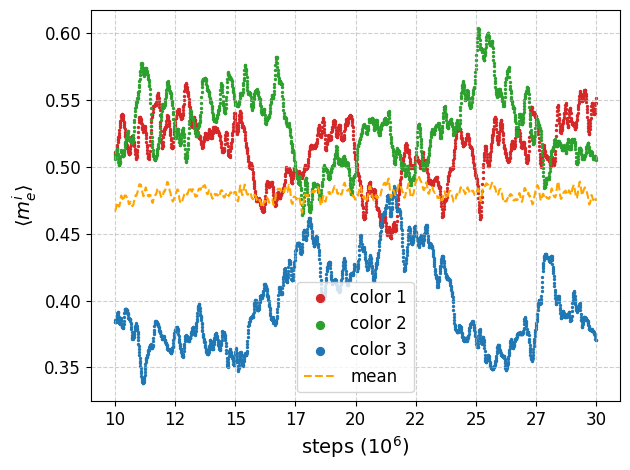

In [123]:
avg = np.mean(m.data['mean_links'], axis=1)[:2_000]
col1 = np.array(m.data['mean_links']).T[0][:2_000]
col2 = np.array(m.data['mean_links']).T[1][:2_000]
col3 = np.array(m.data['mean_links']).T[2][:2_000]

x = np.arange(10_000_000, 30_000_000, 10_000)

plt.scatter(x, smoother(col1), s=2, c='tab:red', label='color 1')
plt.scatter(x, smoother(col2), s=2, c='tab:green', label='color 2')
plt.scatter(x, smoother(col3), s=2, c='tab:blue', label='color 3')
plt.plot(x, smoother(avg), '--', c='orange', label='mean')

#plt.title(r'L = 64    $\beta$ = 2')
plt.xlabel(r'steps ($10^6$)', fontsize=14)
plt.ylabel(r'$\langle m_e^i\rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
#plt.savefig('three_cols_anticorr.pdf')

In [1]:
np.corrcoef(col1, col2)

NameError: name 'np' is not defined

In [107]:
np.corrcoef(col1, col3)

array([[ 1.       , -0.5512918],
       [-0.5512918,  1.       ]])

In [108]:
np.corrcoef(col3, col2)

array([[ 1.        , -0.61571898],
       [-0.61571898,  1.        ]])

# Local Times

In [3]:
with open(r'data/local_times/lt_3_64_2024-06-28_01_51_08.json', 'r') as file:
   data = np.array(json.load(file)['data'])

S = data.shape

In [4]:
def get_corrs(data):
    corr = []
    for i in range(S[2]): #distance 
        X = data[i, 0, :]
        Y = data[i, 1, :]
        corr.append( np.corrcoef(X, Y)[0,1] )
    return corr

arr = []
for i in range(S[1]): #beta
    arr.append([get_corrs(chain[i]) for chain in data])

In [5]:
np.array(arr).shape

(8, 8, 25)

In [6]:
np.mean(np.array(arr), axis=1).shape

(8, 25)

xi = 1.1602109738318411
xi = 1.780902300387788
xi = 4.1956760581588695
xi = 6.943724519145755
xi = 12.250755346283979
xi = 11.571994975907865
xi = 14.573457090408635
xi = 13.622192571782817


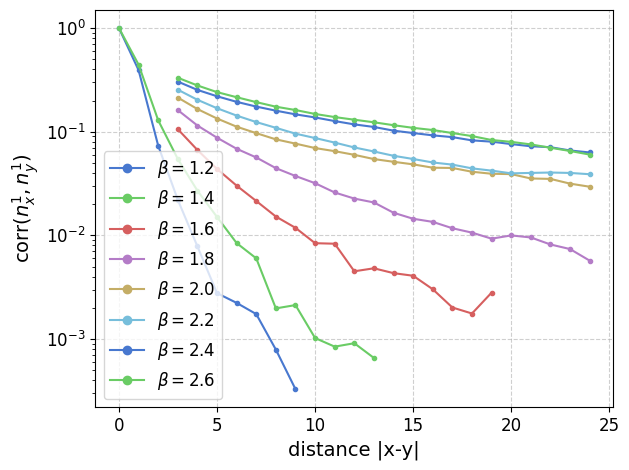

In [43]:
def linear(x, a, b):
    return a*x + b 

corr_lengths = []
corr_errs = []
betas = [1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
max_dists = [10, 14, 20, 25, 25, 25, 25, 25, 25, 25]
min_dist = [0,0,3,3,3,3,3,3]#[0, 3, 5, 5, 5, 4, 4, 4, 4, 4] # #
for i in range(0, S[1]):
    
    plt.plot( np.arange(min_dist[i], max_dists[i]), np.mean(arr, axis=1)[i][min_dist[i]:max_dists[i]], label=r'$\beta = $' +  f'{betas[i]}', marker='.')
    # fit
    p, pcov = curve_fit(linear, np.arange(min_dist[i], max_dists[i]), np.log(np.mean(arr, axis=1)[i][min_dist[i]:max_dists[i]]))  
    #print(f'a = {p[0]} +/- {pcov[0,0]}    b = {p[1]} +/- {pcov[1,1]}')   
    
    #plt.plot(np.linspace(min_dist[i], max_dists[i], 50), np.exp(linear(np.linspace(min_dist[i], max_dists[i], 50), p[0], p[1])), linestyle='--', c='black', alpha=0.4)
    corr_lengths.append( 1/abs(p[0]) )
    corr_errs.append( np.sqrt(pcov[0,0]) * 1/p[0]**2 )
    print(f'xi = {1/abs(p[0])}')
plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'distance |x-y|', fontsize=14)
plt.ylabel(r'corr$(n^1_x, n^1_y)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
#plt.savefig('corr_one_color_logscale.pdf')

xi = 5.619432065667954 +/- 0.12735259111714986
xi = 5.60735469491373 +/- 0.21348345959548498
xi = 4.984403776052388 +/- 0.16883909819807
xi = 4.9617385490769434 +/- 0.2004464068370569


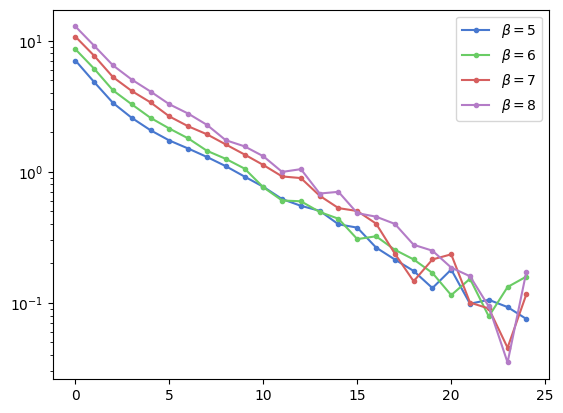

In [22]:
with open(r'data/local_times/lt_3_256_2024-05-27_17_07_59.json', 'r') as file:
   data_2 = np.array(json.load(file)['data'])
   
S = data_2.shape

def get_corrs(data):
    corr = []
    for i in range(S[2]): #distance 
        X = data[i, 0, :]
        Y = data[i, 1, :]
        corr.append( np.corrcoef(X, Y)[0,1] )
    return corr

arr = []
for i in range(S[1]): #beta
   arr.append([get_corrs(chain[i]) for chain in data_2])
   
corr_lengths_2 = []
corr_errs_2 = []
betas = [5, 6, 7, 8]
max_dists = [25, 25, 25, 25]
for i in range(S[1]):
   plt.plot( np.arange(0, max_dists[i]), np.mean(arr, axis=1)[i][:max_dists[i]], label=r'$\beta = $' +  f'{betas[i]}', marker='.')
   plt.legend()
   plt.yscale('log')
   # fit
   p, pcov = curve_fit(linear, np.arange(0, max_dists[i]), np.log(np.mean(arr, axis=1)[i][:max_dists[i]]))  
   corr_errs_2.append( np.sqrt(pcov[0,0]) * 1/p[0]**2 )  
   print(f'xi = {1/abs(p[0])} +/- { np.sqrt(pcov[0,0]) * 1/p[0]**2}')
   
   corr_lengths_2.append( 1/abs(p[0]) )

xi = 6.24426480131927 +/- 0.18886748611678916
xi = 5.038360262718725 +/- 0.13044222778333742


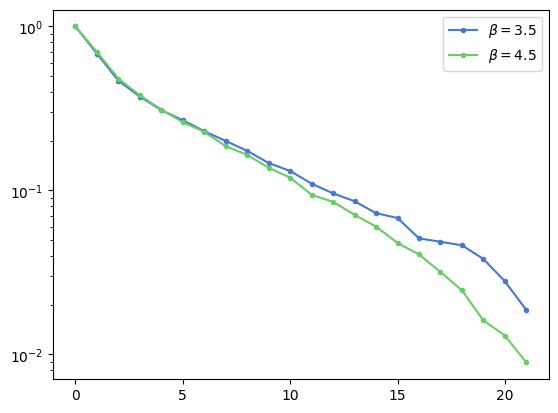

In [24]:
with open(r'data/local_times/lt_3_256_2024-05-27_18_30_18.json', 'r') as file:
   data_3 = np.array(json.load(file)['data'])
   
S = data_3.shape

def get_corrs(data):
    corr = []
    for i in range(S[2]): #distance 
        X = data[i, 0, :]
        Y = data[i, 1, :]
        corr.append( np.corrcoef(X, Y)[0,1] )
    return corr

arr = []
for i in range(S[1]): #beta
   arr.append([get_corrs(chain[i]) for chain in data_3])
   
corr_lengths_3 = []
corr_errs_3 = []
betas = [3.5, 4.5]
max_dists = [22, 22]
for i in range(S[1]):
   plt.plot( np.arange(0, max_dists[i]), np.mean(arr, axis=1)[i][:max_dists[i]], label=r'$\beta = $' +  f'{betas[i]}', marker='.')
   plt.legend()
   plt.yscale('log')
   # fit
   p, pcov = curve_fit(linear, np.arange(0, max_dists[i]), np.log(np.mean(arr, axis=1)[i][:max_dists[i]]))  
   corr_errs_3.append( np.sqrt(pcov[0,0]) * 1/p[0]**2 )  
   print(f'xi = {1/abs(p[0])} +/- { np.sqrt(pcov[0,0]) * 1/p[0]**2}')
   
   corr_lengths_3.append( 1/abs(p[0]) )

a = 9.5207317389781 +/- 0.23370502153245132    b = -10.657141830998555 +/- 0.3275709500174646


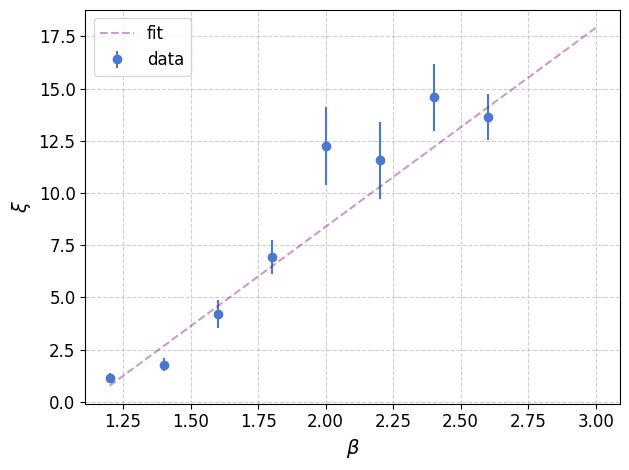

In [45]:
X = [1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
Y = corr_lengths #+ corr_lengths_2 + corr_lengths_3
Y_err = corr_errs #+ corr_errs_2 +corr_errs_3

#Y[4] = 10.32
#Y[6] = 12.65
def linear(x, a, b):
    return a*x + b 

def my_sqrt(x, a, b):
    return a*np.sqrt(x) + b

plt.errorbar(X, Y, yerr=np.array(Y_err)*2.5, label='data', marker='o', fmt=' ')

p, pcov = curve_fit(linear, X, Y, sigma=Y_err, absolute_sigma=True)  
print(f'a = {p[0]} +/- {np.sqrt(pcov[0,0])}    b = {p[1]} +/- {np.sqrt(pcov[1,1])}')   
    
plt.plot(np.linspace(1.2, 3, 50), linear(np.linspace(1.2, 3, 50), p[0], p[1]), linestyle='--', c='purple', alpha=0.4, label='fit')

plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'$\xi$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig('corr_lengths.pdf')

a = 2.7000039781168246 +/- 0.08821087732852936    b = -1.9782619589322676 +/- 0.18762205717351213


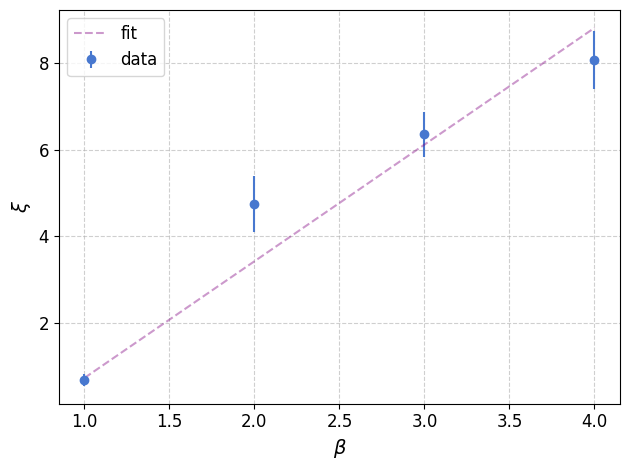

In [40]:
X = [1,2,3,4] #list(range(1,9)) + [3.5, 4.5]
Y = corr_lengths #+ corr_lengths_2 + corr_lengths_3
Y_err = corr_errs #+ corr_errs_2 +corr_errs_3

def linear(x, a, b):
    return a*x + b 

def my_sqrt(x, a, b):
    return a*np.sqrt(x) + b

plt.errorbar(X, Y, yerr=np.array(Y_err)*2.5, label='data', marker='o', fmt=' ')

p, pcov = curve_fit(linear, X, Y, sigma=Y_err)  
print(f'a = {p[0]} +/- {pcov[0,0]}    b = {p[1]} +/- {pcov[1,1]}')   
    
plt.plot(np.linspace(1, 4, 50), linear(np.linspace(1, 4, 50), p[0], p[1]), linestyle='--', c='purple', alpha=0.4, label='fit')

plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'$\xi$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig('corr_lengths.pdf')

# Loops

main questions: avg loop lenght vs beta 
confirm that no marco loops exists, show that $|l_{longest}| / |\Lambda| \to 0$ when $L \to \infty$

In [ ]:
# 32

with open(r'data\\loops\\loops_32_2024-05-30_13_34_35.json', 'r') as file:
        data_raw = json.load(file)

data = {
    'mean_loop_length': np.array(data_raw['results'])[:, :, :, 0], 
    'longest_loop': np.array(data_raw['results'])[:, :, :, 1] 
}

coords = {
    'betas': data_raw['params']['betas']
}

dims = {
    'mean_loop_length': ['beta'],
    'longest_loop': ['beta']
}

idata = az.convert_to_inference_data(data, coords=coords, dims=dims)


mean_lenght_32, longest_loop_32 = az.summary(idata)['mean'][:4], az.summary(idata)['mean'][4:]
mean_lenght_32_sigma, longest_loop_32_sigma = az.summary(idata)['mcse_mean'][:4], az.summary(idata)['mcse_mean'][4:]
az.summary(idata)

In [11]:
# 64

with open(r'data\loops\loops_64_2024-05-29_12_46_34.json', 'r') as file:
        data_raw = json.load(file)

data = {
    'mean_loop_length': np.array(data_raw['results'])[:, :, :, 0], 
    'longest_loop': np.array(data_raw['results'])[:, :, :, 1] 
}

coords = {
    'betas': data_raw['params']['betas']
}

dims = {
    'mean_loop_length': ['beta'],
    'longest_loop': ['beta']
}

idata = az.convert_to_inference_data(data, coords=coords, dims=dims)
mean_lenght_64, longest_loop_64 = az.summary(idata)['mean'][:4], az.summary(idata)['mean'][4:]
mean_lenght_64_sigma, longest_loop_64_sigma = az.summary(idata)['mcse_mean'][:4], az.summary(idata)['mcse_mean'][4:]

In [53]:
with open(r'data\\loops\\loops_128_2024-05-29_21_44_00.json', 'r') as file:
        data_raw = json.load(file)

data = {
    'mean_loop_length': np.array(data_raw['results'])[:, :, :, 0], 
    'longest_loop': np.array(data_raw['results'])[:, :, :, 1] 
}

coords = {
    'betas': data_raw['params']['betas']
}

dims = {
    'mean_loop_length': ['beta'],
    'longest_loop': ['beta']
}

idata = az.convert_to_inference_data(data, coords=coords, dims=dims)
mean_lenght_128, longest_loop_128 = az.summary(idata)['mean'][:4].values, az.summary(idata)['mean'][4:].values
mean_lenght_128_sigma, longest_loop_128_sigma = az.summary(idata)['mcse_mean'][:4].values, az.summary(idata)['mcse_mean'][4:].values

In [ ]:
# 96
with open(r'data\\loops\\loops_96_2024-05-30_17_30_57.json', 'r') as file:
        data_raw = json.load(file)

data = {
    'mean_loop_length': np.array(data_raw['results'])[:, :, :, 0], 
    'longest_loop': np.array(data_raw['results'])[:, :, :, 1] 
}

coords = {
    'betas': data_raw['params']['betas']
}

dims = {
    'mean_loop_length': ['beta'],
    'longest_loop': ['beta']
}

idata = az.convert_to_inference_data(data, coords=coords, dims=dims)
az.summary(idata)

In [3]:
def read_loops_data(file_name):
    with open(file_name, 'r') as file:
        data_raw = json.load(file)
    data = {
    'mean_loop_length': np.array(data_raw['results'])[:, :, :, 0], 
    'longest_loop': np.array(data_raw['results'])[:, :, :, 1] 
    }

    coords = {
        'betas': data_raw['params']['betas']
    }

    dims = {
        'mean_loop_length': ['beta'],
        'longest_loop': ['beta']
    }

    idata = az.convert_to_inference_data(data, coords=coords, dims=dims)

    mean_lenght, longest_loop = az.summary(idata)['mean'][:4].values, az.summary(idata)['mean'][4:].values
    mean_lenght_sigma, longest_loop_sigma = az.summary(idata)['mcse_mean'][:4].values, az.summary(idata)['mcse_mean'][4:].values
    
    return mean_lenght, longest_loop, mean_lenght_sigma, longest_loop_sigma

loops_data_files = [
    'data\\loops\\loops_32_2024-05-30_13_34_35.json',
    'data\loops\loops_64_2024-05-29_12_46_34.json',
    'data\\loops\\loops_96_2024-05-30_17_30_57.json',
    'data\\loops\\loops_128_2024-05-29_21_44_00.json'
]

mean_length = []
longest_loop = []

mean_length_sigma = []
longest_loop_sigma = []

for file in loops_data_files:
    ml, ll, mls, lls = read_loops_data(file)
    mean_length.append(ml)
    longest_loop.append(ll) 
    mean_length_sigma.append(mls)
    longest_loop_sigma.append(lls) 

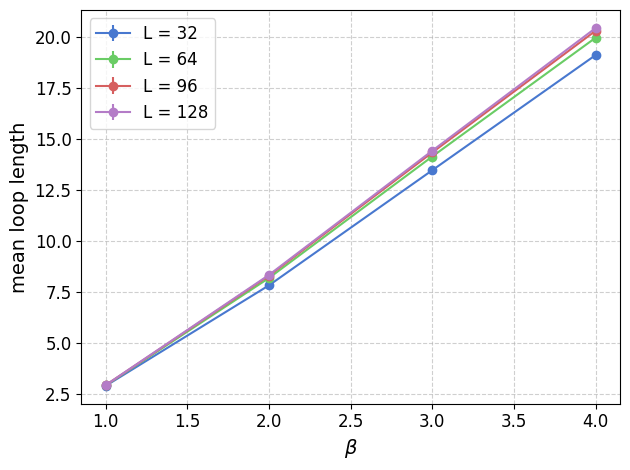

In [15]:
L = [32, 64, 96, 128]

for i in range(4):
    plt.errorbar(x=[1,2,3,4], y=mean_length[i], yerr=mean_length_sigma[i], label=f'L = {L[i]}', marker='o')

plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('mean loop length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig('mean_loop_length_beta.pdf')

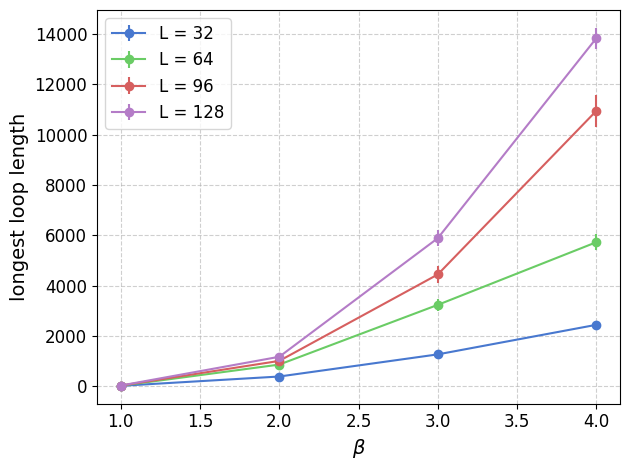

In [14]:
for i in range(4):
    plt.errorbar(x=[1,2,3,4], y=longest_loop[i], yerr=longest_loop_sigma[i], label=f'L = {L[i]}', marker='o')

plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('longest loop length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\loops\longest_loop_beta.pdf')

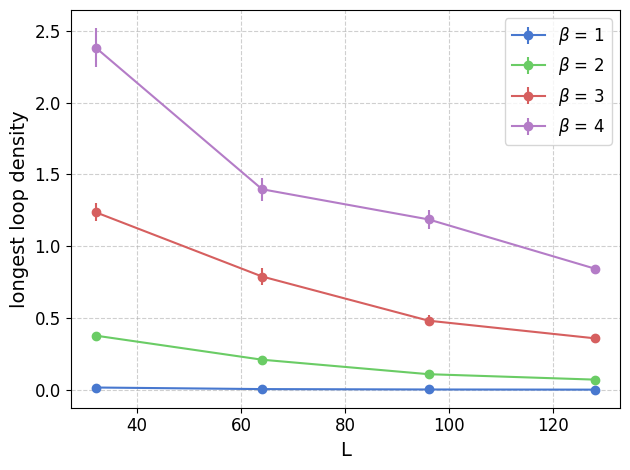

In [16]:
betas = [1,2,3,4]
longest_density = np.array([longest_loop[i] / L[i]**2 for i in range(4)])
sigma = np.array([longest_loop_sigma[i] / L[i]**2 for i in range(4)]).T
Ls = [L]*4
for i in range(4):
    plt.errorbar( x=Ls[i], y=longest_density.T[i], yerr=sigma[i], marker='o', label= r'$\beta$ = ' + f'{betas[i]}')
plt.xlabel('L', fontsize=14)
plt.ylabel('longest loop density', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\loops\longest_loop_density.pdf')

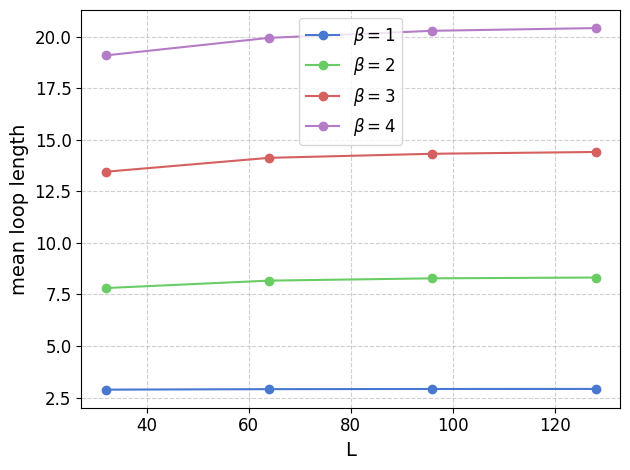

In [12]:
betas = [1,2,3,4]
for i in range(4):
    plt.plot(L, np.array(mean_length).T[i], marker='o', label=r'$\beta = $' + f'{betas[i]}')
plt.xlabel('L', fontsize=14)
plt.ylabel('mean loop length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\loops\mean_loop_length_L.pdf')

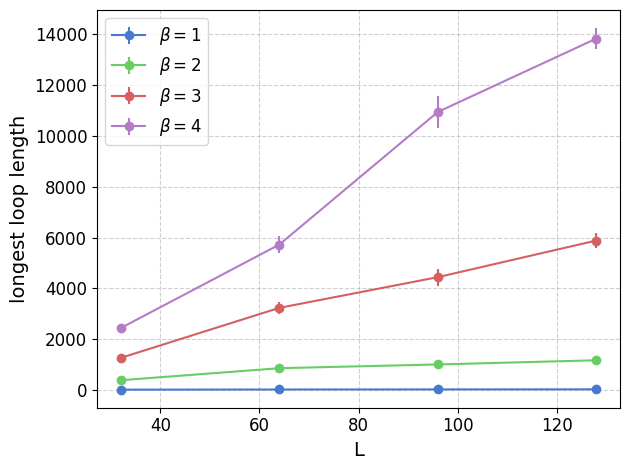

In [13]:
betas = [1,2,3,4]
for i in range(4):
    plt.errorbar(L, np.array(longest_loop).T[i], yerr= np.array(longest_loop_sigma).T[i], marker='o', label=r'$\beta = $' + f'{betas[i]}')
plt.xlabel('L', fontsize=14)
plt.ylabel('longest loop length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\loops\longest_loop_L.pdf')

In [32]:
# some fits 

def linear(x, a, b):
    return a*x + b 

def my_exp(x, a, b, c):
    return a*np.exp(b*x) + c

def my_pow(x, a, b):
    return a*x**b 

# mean loop length vs beta (linear) 
x = [1,2,3,4] 
y = mean_length[-1]

p, pcov = curve_fit(linear, x, y) 
print(f'a = {p[0]} +/- {np.sqrt(pcov[0,0])}        b = {p[1]} +/- {np.sqrt(pcov[1,1])}') 

# longest loop length vs beta (exp) 

y = longest_loop[-2]

p, pcov = curve_fit(linear, x, np.log(y)) 
print(f'a = {p[0]} +/- {np.sqrt(pcov[0,0])}        b = {p[1]} +/- {np.sqrt(pcov[1,1])}')

a = 5.856499993817812 +/- 0.11016964656846054        b = -3.129499981378123 +/- 0.30171200148302135
a = 1.9580361321018043 +/- 0.4484232265772988        b = 2.075166455906227 +/- 1.2280575981295092


In [33]:
p, pcov = curve_fit(my_pow, x, y) 
print(f'a = {p[0]} +/- {np.sqrt(pcov[0,0])}        b = {p[1]} +/- {np.sqrt(pcov[1,1])}')

a = 123.79992617128151 +/- 18.62198919370382        b = 3.2343540897621867 +/- 0.11173249316663915


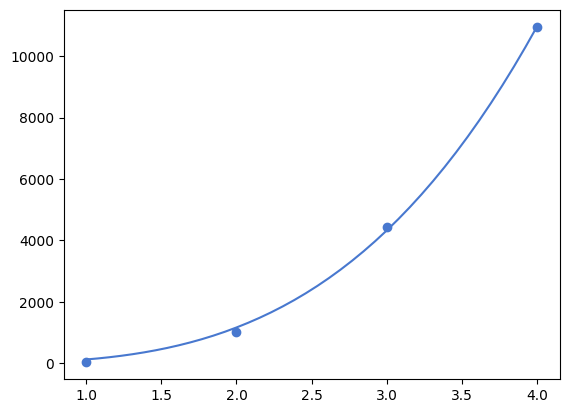

In [34]:
plt.plot(np.linspace(1,4,40), my_pow(np.linspace(1,4,40), *p) )
plt.scatter(x, y)

### N = 2

In [11]:
def read_loops_data(file_name):
    with open(file_name, 'r') as file:
        data_raw = json.load(file)
    data = {
    'mean_loop_length': np.array(data_raw['results'])[:, :, :, 0], 
    'longest_loop': np.array(data_raw['results'])[:, :, :, 1],
    'mean_visits': np.array(data_raw['results'])[:, :, :, 2], 
    'max_visits': np.array(data_raw['results'])[:, :, :, 3]  
    }

    coords = {
        'betas': data_raw['params']['betas']
    }

    dims = {
        'mean_loop_length': ['beta'],
        'longest_loop': ['beta'],
        'mean_visits': ['beta'],
        'max_visits': ['beta']
    }

    idata = az.convert_to_inference_data(data, coords=coords, dims=dims)

    #mean_lenght, longest_loop = az.summary(idata, kind='stats')['mean'][:4].values, az.summary(idata)['mean'][4:].values
    #mean_lenght_sigma, longest_loop_sigma = az.summary(idata)['mcse_mean'][:4].values, az.summary(idata)['mcse_mean'][4:].values
    
    return idata

idata_loops_XY = read_loops_data(r'data\\loops\\XY_loops_64_2024-06-19_12_42_50.json')
idata_loops_XY

Inference data with groups:
	> posterior

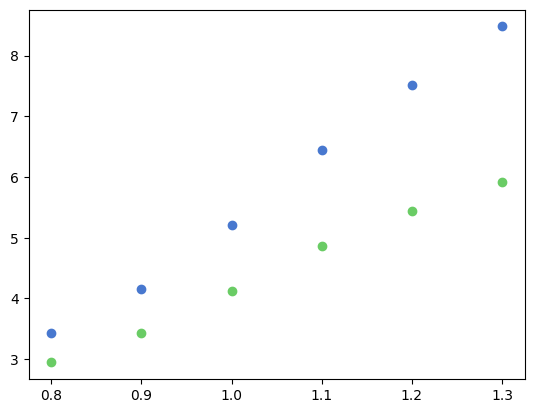

In [27]:
mll = np.mean(idata_loops_XY.posterior['mean_loop_length'].values, axis=(0,1))
ll = np.mean(idata_loops_XY.posterior['longest_loop'].values, axis=(0,1))
mv = np.mean(idata_loops_XY.posterior['mean_visits'].values, axis=(0,1))
max_v = np.mean(idata_loops_XY.posterior['max_visits'].values, axis=(0,1))

data = [mll, mv]
betas = np.arange(0.8, 1.4, 0.1)
for d in data:
    plt.scatter(betas, d)




In [10]:
mean_loop_length = az.summary(idata_loops_XY)['mean'].values[:5]


array([   3.425,    4.158,    5.217,    6.438,    7.512,    8.481,
         40.47 ,   85.807,  215.069,  536.052,  850.293, 1173.72 ,
          2.946,    3.431,    4.118,    4.865,    5.447,    5.915,
         30.672,   63.255,  152.022,  360.495,  541.457,  709.028])

### Loop art

In [72]:
#m = StateSpace(2, 64, 0.8)
m.beta = 1.8
m.step(50_000_000)



  0%|          | 0/50000000 [00:00<?, ?it/s]

In [4]:
m.load_data('loop_art')

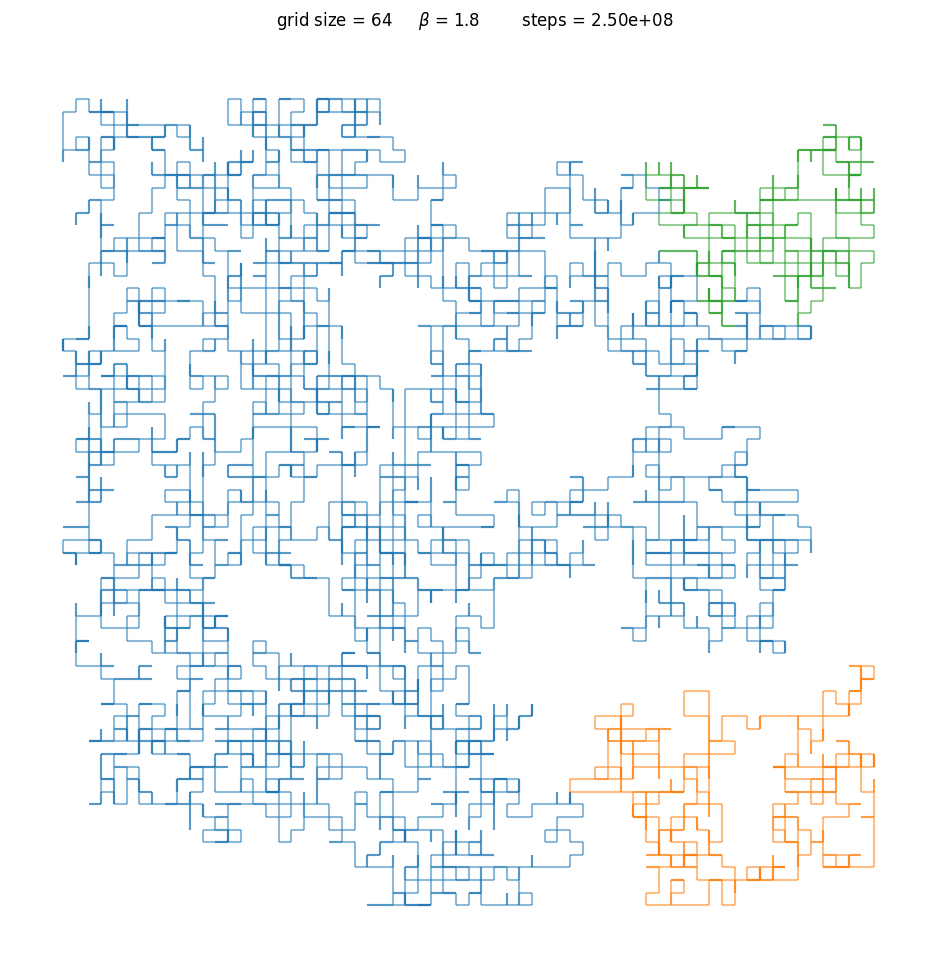

In [78]:
#plt.style.use('dark_background')
plt.style.use('default')
plt.style.use('seaborn-v0_8-muted')

loops, lengths, _ = m.loop_builder()

def k_greatest_indices(lst, k):
    # Convert list to NumPy array
    arr = np.array(lst)
    
    # Get the indices that would sort the array
    sorted_indices = np.argsort(arr)
    
    # Select the last k indices (the k largest elements)
    k_largest_indices = sorted_indices[-k:]
    
    # Since argsort returns indices in ascending order, reverse them to get the largest first
    k_largest_indices = k_largest_indices[::-1]
    
    return k_largest_indices

top_idx_0 = k_greatest_indices(lengths[0], k=3)
top_idx_1 = k_greatest_indices(lengths[1], k=3)
#top_idx_2 = k_greatest_indices(lengths[2], k=1)

top_loops_1 = [[loops[0][i] for i in top_idx_0], []] # [loops[1][i] for i in top_idx_1], [loops[2][i] for i in top_idx_2] ]
top_loops_2 = [[], [loops[1][i] for i in top_idx_1]]

m.plot_loop_overlap(top_loops_2, alpha_links=0., alpha_loop=0.5, linewidth=1.5)

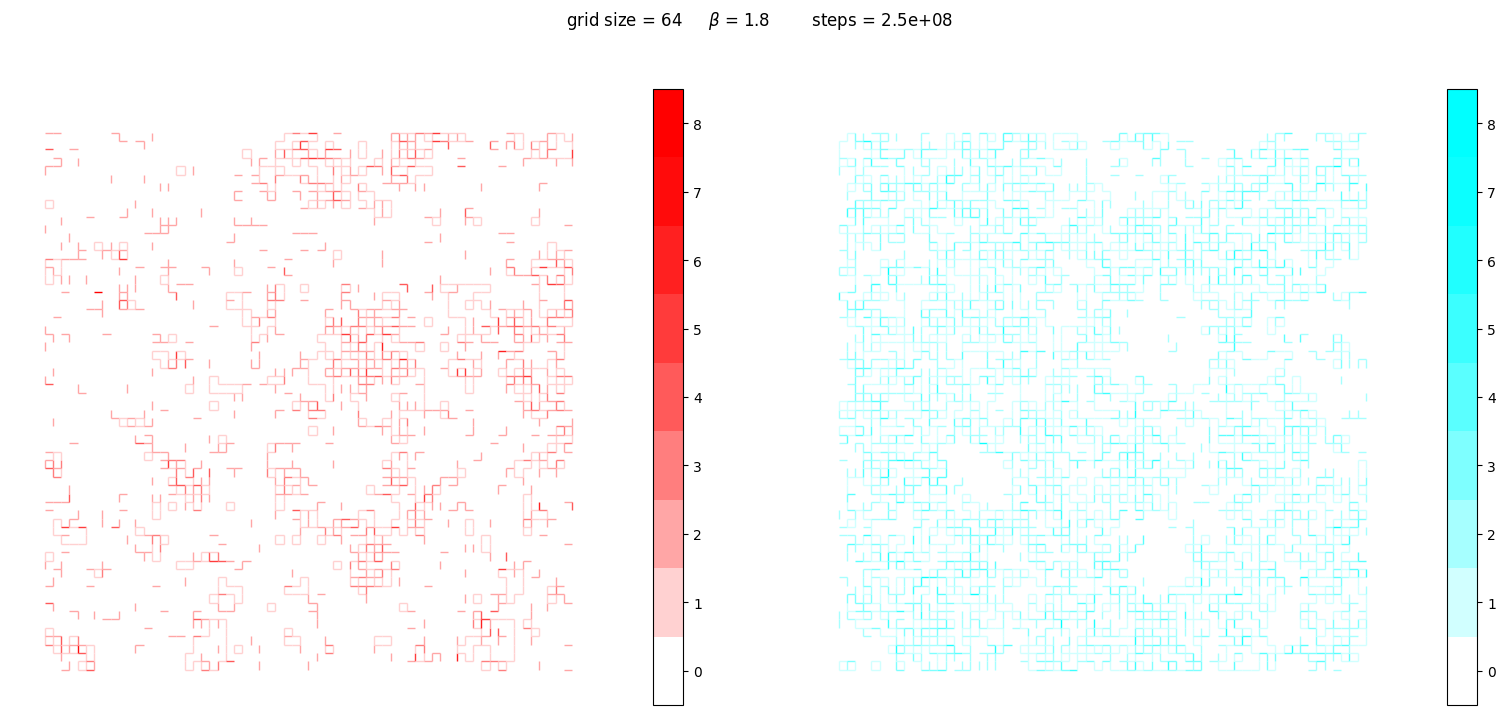

mean number of links: [0.44177246 1.08081055]
max number of links: [8 8]
mean local time: 3.1191735953640713


ValueError: too many values to unpack (expected 2)

In [80]:
m.plot_grid()
m.summary()

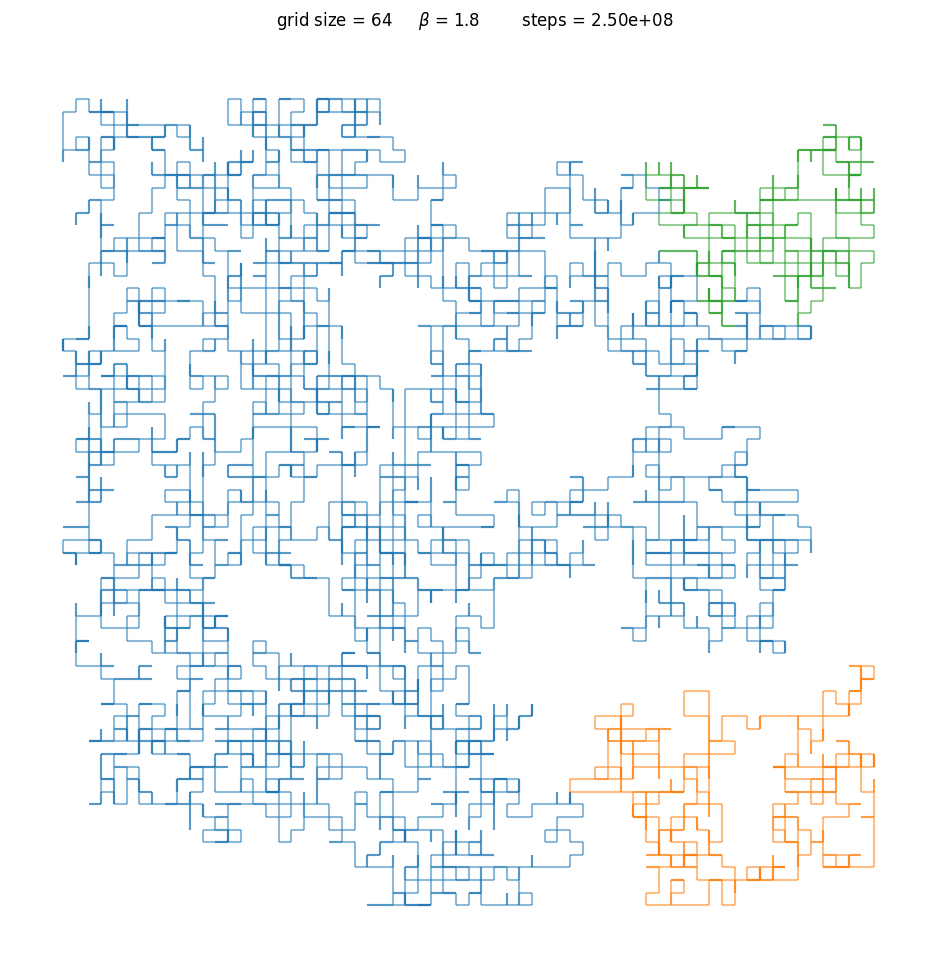

In [79]:
m.plot_loop_overlap(top_loops_2, alpha_links=0., linewidth=1.5, alpha_loop=0.5, file_name='XY_beta_18.pdf')

# Connection prob

starting from _empty_ or _snake_ changed the decayo from always exponential to always algebraic. 
Explanations:
- convergence was not reached! long loops take a long time!
- who is closer to eq? 
Check: do some loong run with a fixed beta = 2, hope that snake and empty eventually agree!

In [158]:
def connectivity_data_merge(file_1, file_2):
    # read data
    with open(file_1, 'r') as file:
        data_raw_1 = json.load(file)
    with open(file_2, 'r') as file:
        data_raw_2 = json.load(file)
    
    # find betas 
    betas_1 = data_raw_1['params']['betas']
    betas_2 = data_raw_2['params']['betas'] 
    
    betas_merged = betas_1 + betas_2
    
    # merge the data in ascending order (assumes betas are distinct)
    # Step 2: Sort the merged list and track the indices
    betas_sorted = sorted(range(len(betas_merged)), key=lambda k: betas_merged[k])

    # Step 3: Create the sorted list based on sorted indices
    permutation = [betas_merged[i] for i in betas_sorted]

    print("Merged List:", betas_merged)
    print("Sorted Merged List:", betas_sorted)
    print("Permutation Indices:", permutation)
    
    max_distance = data_raw_1['params']['grid_size'] // 2
    
    # Step 1: Merge the lists along the third axis (axis=2)
    merged_data = np.concatenate((data_raw_1['results'], data_raw_2['results']), axis=2)  # Shape (8, 5000, 8, 64)

    # Sort the list based on the last element of each sublist
    merged_data_sorted = sorted(merged_data, key=lambda x: x[0,0,)   
    
    data = {
    'connectivity': sorted_merged_list
    }

    coords = {
        'betas': betas_sorted,
        'distance': range(1, max_distance+1)
    }

    dims = {
        'connectivity': ["beta", "distance"],

    }

    idata = az.convert_to_inference_data(data, coords=coords, dims=dims)
                
    return idata
    
    
    
idata = connectivity_data_merge(r'data\\corr\\corr_128_2024-05-31_17_07_49.json', r'data\\corr\\corr_128_2024-05-31_14_15_02.json')

Merged List: [1.2, 1.4, 1.6, 1.8, 1, 2, 3, 4]
Sorted Merged List: [4, 0, 1, 2, 3, 5, 6, 7]
Permutation Indices: [1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]


In [9]:
def read_conn_data(file_name):
    
    with open(file_name, 'r') as file:
        data_raw = json.load(file)
    
    max_distance = data_raw['params']['grid_size'] // 2
    
    data = {
    'connectivity': np.array(data_raw['results'])
    }

    coords = {
        'beta': data_raw['params']['betas'],
        'distance': range(1, max_distance+1)
    }

    dims = {
        'connectivity': ["beta", "distance"],

    }

    idata = az.convert_to_inference_data(data, coords=coords, dims=dims)
                
    return idata


In [ ]:
#idata_128= read_conn_data(r'data\corr\XY_corr_128_2024-06-04_15_30_46.json')
#idata_256= read_conn_data(r'data\\corr\\3_corr_128_2024-06-12_00_35_01.json') # N = 3 snake init
idata_empty_short = read_conn_data(r'data\\corr\\XY_empty_corr_64_2024-06-12_13_18_52.json')
idata_snake = read_conn_data(r'data\\corr\\XY_snake_corr_64_2024-06-12_11_53_42.json')
idata_empty = read_conn_data(r'data\\corr\\XY_empty_corr_64_2024-06-12_12_25_05.json')
idata_snake_short = read_conn_data(r'data\\corr\\XY_snake_corr_64_2024-06-12_13_21_44.json')

In [73]:
idata_empty_50M = read_conn_data(r'data\corr\XY_empty_50M_corr_64_2024-06-12_13_53_42.json')
idata_empty_100M = read_conn_data(r'data\\corr\\XY_empty_100M_corr_64_2024-06-12_14_08_24.json')
idata_empty_200M = read_conn_data(r'data\\corr\\XY_empty_200M_corr_64_2024-06-12_14_47_50.json')
idata_empty_70M = read_conn_data(r'data\\corr\\XY_empty_70M_corr_64_2024-06-12_15_08_33.json')

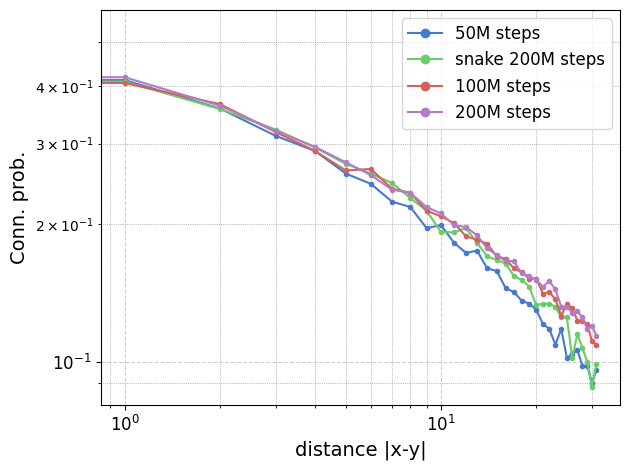

In [78]:
y_50M = np.reshape(az.summary(idata_empty_50M, kind='stats')['mean'].values, (1, 32))
y_70M = np.reshape(az.summary(idata_empty_70M, kind='stats')['mean'].values, (1, 32)) 
y_100M = np.reshape(az.summary(idata_empty_100M, kind='stats')['mean'].values, (1, 32)) 
y_200M = np.reshape(az.summary(idata_empty_200M, kind='stats')['mean'].values, (1, 32)) 
y_snake = np.reshape(az.summary(idata_snake, kind='stats')['mean'].values, (1, 32)) 

plt.plot(y_50M[0], label='50M steps', marker='.')
plt.plot(y_snake[0], label='snake 200M steps', marker='.')
plt.plot(y_100M[0], label='100M steps', marker='.')
plt.plot(y_200M[0], label='200M steps', marker='.')

plt.xscale('log')      
plt.yscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel('Conn. prob.', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
#plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_conn_conv.pdf')

In [62]:
yss_err = az.summary(idata_snake_short)['mcse_mean'].values
yes_err = az.summary(idata_empty_short)['mcse_mean'].values
ys_err = az.summary(idata_snake)['mcse_mean'].values
ye_err = az.summary(idata_empty)['mcse_mean'].values

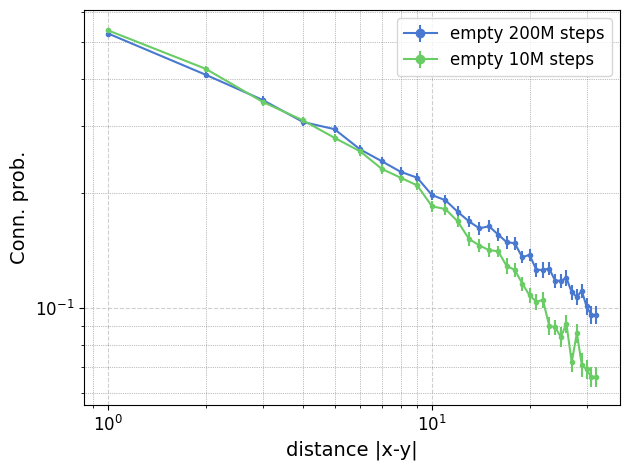

In [65]:
y_snake = np.reshape(az.summary(idata_snake, kind='stats')['mean'].values, (1, 32)) 
y_empty = np.reshape(az.summary(idata_empty, kind='stats')['mean'].values, (1, 32)) 
y_empty_short = np.reshape(az.summary(idata_empty_short, kind='stats')['mean'].values, (1, 32)) 
y_snake_short = np.reshape(az.summary(idata_snake_short, kind='stats')['mean'].values, (1, 32)) 

betas = idata_snake['posterior'].coords['beta'].values

for i in range(1):
    #plt.scatter(np.arange(1, len(y_256)+1), y_256[i], label = f'{betas[i]}', zorder=1, s=8)
    #plt.scatter(np.arange(1, len(y_128)+1), y_128[i], label = f'{betas[i]}', zorder=2, s=8)
    x = np.arange(1, 33)
    #plt.errorbar(x, y_snake[i], yerr=ys_err, label='snake 200M steps',  marker='+')
    plt.errorbar(x, y_empty[i], yerr=ye_err, label='empty 200M steps', marker='.')
    plt.errorbar(x, y_empty_short[i], yerr=yes_err, label='empty 10M steps', marker='.')
    #plt.errorbar(x, y_snake_short[i], yerr=yss_err, label='snake 10M steps', marker='.')

plt.xscale('log')      
plt.yscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel('Conn. prob.', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
#plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_snake_init_test_beta_2.pdf')


               beta = 1
--- exp ---
a = 0.423 +/- 0.000    b = 0.626 +/- 0.000   res = 9.558e-04
--- pow ---
a = 1.371 +/- 0.015      b = 1.289 +/- 0.004      c = -2.140 +/- 0.002      res = 2.194e-05

best fit: pow 

               beta = 2
--- exp ---
a = 0.374 +/- 0.000    b = 0.040 +/- 0.000   res = 6.500e-02
--- pow ---
a = 1.200 +/- 0.008      b = 2.404 +/- 0.079      c = -0.691 +/- 0.000      res = 4.132e-03

best fit: pow 

               beta = 3
--- exp ---
a = 0.503 +/- 0.000    b = 0.022 +/- 0.000   res = 5.748e-02
--- pow ---
a = 1.762 +/- 0.023      b = 5.647 +/- 0.422      c = -0.556 +/- 0.000      res = 6.214e-03

best fit: pow 

               beta = 4
--- exp ---
a = 0.587 +/- 0.000    b = 0.015 +/- 0.000   res = 3.863e-02
--- pow ---
a = 2.041 +/- 0.047      b = 9.634 +/- 1.580      c = -0.475 +/- 0.001      res = 7.150e-03

best fit: pow 


C:\Users\lollo\AppData\Local\Temp\ipykernel_27272\2512582965.py:27: RuntimeWarning: invalid value encountered in power
  p, pcov = curve_fit(lambda x, a, b, c: a*(x+b)**c, x_short, y, p0 = (1, 1, -1), maxfev=50_000, nan_policy='omit')


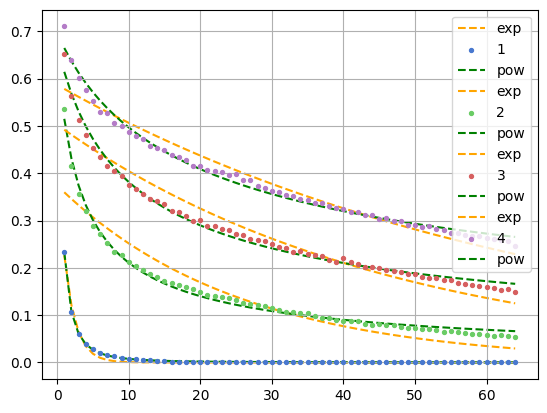

In [87]:

y = np.reshape(az.summary(idata_XY_long, kind='stats')['mean'].values, (4, 64)) 

#y = y[:, :32]

betas = idata_XY_long['posterior'].coords['beta'].values
#betas = [1,1.5,2]

def fit_plot(data, betas):
    x = np.arange(1, len(data[0])+1)
    x_short = x #np.arange(10, len(data[0])+1)
    for i in range(len(data)):
        print(f'\n               beta = {betas[i]}')
        # fit best exp
        y = data[i]
        p, pcov = curve_fit(lambda x, a, b: a*np.exp(-b*x) , x_short, y, p0 = (1, 1), maxfev=50_000, nan_policy='omit')
        x_fit = np.arange(1, len(data[0])+1)
        y_fit_exp = p[0]*np.exp(-p[1]*x_fit) 
        res_exp = np.sum( (y-y_fit_exp)**2)
        print('--- exp ---')
        print('a = {:.3f} +/- {:.3f}    b = {:.3f} +/- {:.3f}   res = {:.3e}'.format(p[0], pcov[0,0], p[1], pcov[1,1], res_exp))
       
        plt.plot(x_fit, y_fit_exp, label = 'exp', color = 'orange', linestyle = '--', zorder = 1)
        plt.scatter(x, y, label = f'{betas[i]}', zorder=2, s=8)

        # fit best pow
        try:
            p, pcov = curve_fit(lambda x, a, b, c: a*(x+b)**c, x_short, y, p0 = (1, 1, -1), maxfev=50_000, nan_policy='omit')
        except:
            print('pow fit not working!')
        y_fit_pow = p[0]*(x_fit+p[1])**p[2]
        res_pow = np.sum( (y-y_fit_pow)**2)
        print('--- pow ---')
        print('a = {:.3f} +/- {:.3f}      b = {:.3f} +/- {:.3f}      c = {:.3f} +/- {:.3f}      res = {:.3e}'.format(p[0], pcov[0,0], p[1], pcov[1,1], p[2], pcov[2,2], res_pow))
        plt.plot(x_fit, y_fit_pow, label = 'pow', color = 'green', linestyle = '--', zorder = 1)
        
        print(f"\nbest fit: {'exp' if res_pow > res_exp else 'pow'} ")   
    plt.legend()
    plt.grid()
    plt.show()
    
fit_plot(y, betas)

### N = 3

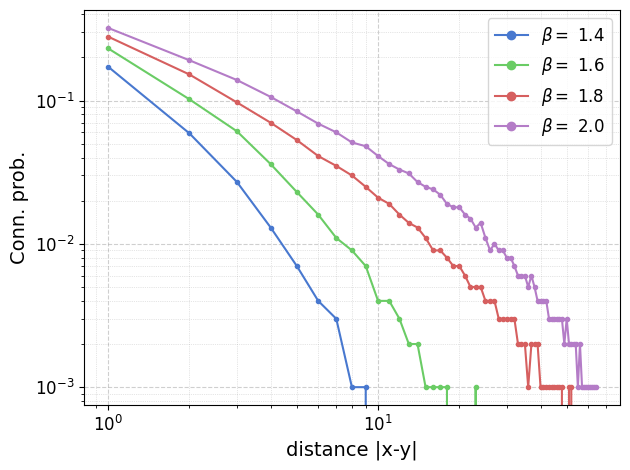

In [37]:
idata_3 = read_conn_data(r'data\\corr\\XY_corr_128_2024-06-15_18_26_48.json')
y = np.reshape(az.summary(idata_3, kind='stats')['mean'].values, (4, 64))

betas = idata_3['posterior'].coords['beta'].values


for i in range(0,4):
    x = np.arange(1,65)
    plt.plot(x, y[i], '.-', label=r'$\beta = $ ' + f'{betas[i]}')
    #plt.plot(x, y_old[i][:64], '.-', label=r'old $\beta = $ ' + f'{betas[i]}')
   
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel('Conn. prob.', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\3_conn_loglog_.pdf')

### Residue plots

In [56]:
def exp_or_poly(X, Y):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    # exp fit
    print('--- Exp ---')
    try:
        p, pcov = curve_fit(lambda x, a, b, c: a*np.exp(-b*x) + c, x=X, y=Y, p0 = (1, 1, 0), maxfev=10_000)
        print('a = {:.3f} +/- {:.3f}      b = {:.3f} +/- {:.3f}      c = {:.3f} +/- {:.3f}      res = {:.3e}'.format(p[0], pcov[0,0], p[1], pcov[1,1], p[2], pcov[2,2], res_pow))
    except:
        print('Exp fit not converging')
        p = [0,0,0]
        pcov = np.zeros((3,3))
    x_fit = X
    y_fit_exp = p[0]*np.exp(-p[1]*x_fit) + p[2]
    res_exp = np.sum( (Y-y_fit_exp)**2)
    axs[0,0].set_title('Exp')
    axs[0,1].set_title(f'Exp res = {res_exp:.3e}')
    axs[0,0].plot(x_fit, y_fit_exp, label = 'exp', color = 'orange', linestyle = '--', zorder = 1)
    axs[0,0].scatter(x=X, y=Y, label ='data', zorder=2, s=8)
    
    # pow fit
    print('--- Pow ---')
    try:
        p, pcov = curve_fit(lambda x, a, b, c: a*(x+b)**c, x, y, p0 = (1, 1, -1), maxfev=50_000, nan_policy='omit')
        print('a = {:.3f} +/- {:.3f}      b = {:.3f} +/- {:.3f}      c = {:.3f} +/- {:.3f}      res = {:.3e}'.format(p[0], pcov[0,0], p[1], pcov[1,1], p[2], pcov[2,2], res_pow))
    except:
        print('Pow fit not converging')
        p = [0,0,0]
        pcov = np.zeros((3,3))
    y_fit_pow = p[0]*(x_fit+p[1])**p[2]
    res_pow = np.sum( (Y-y_fit_pow)**2)
    axs[1,0].plot(x_fit, y_fit_pow, label = 'pow', color = 'green', linestyle = '--', zorder = 1)
    axs[1,0].scatter(x=X, y=Y, label ='data', zorder=2, s=8)
    # plot residues 
    axs[1,0].set_title('Pow')
    axs[1,1].set_title(f'Pow res = {res_pow:.3e}')
    axs[0,1].plot(y_fit_exp - Y, label='exp res')
    axs[1,1].plot(y_fit_pow - Y, label='pow res')
    
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
exp_or_poly(np.arange(1, 65), y[2])

### N = 2

analyze the BKT phase transition

In [3]:
idata_XY_long = read_conn_data(r'data\\corr\\XY_corr_128_2024-06-15_15_05_46.json')
betas = idata_XY_long['posterior'].coords['beta'].values
y = np.reshape(az.summary(idata_XY_long)['mean'].values, (4, 64)) 

for i in range(0,4):
    x = np.arange(1,65)
    x_fit = np.arange(1,65)
    plt.plot(x, y[i], '.-', label=r'$\beta = $ ' + f'{betas[i]}')
    #plt.plot(x, y_old[i][:64], '.-', label=r'old $\beta = $ ' + f'{betas[i]}')
    # linear fit here
    y_fit_data = np.log(y[i]) 

    # Identify inf and NaN values
    is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)

    # Filter out inf and NaN values
    y_fit_data = y_fit_data[~is_inf_or_nan] 
    
    p, pcov = curve_fit(lambda x, a, b: a*x +b, np.log(np.array(x_fit[:len(y_fit_data)])), y_fit_data)
    print(f'{p[0]} +/ {np.sqrt(pcov[0,0])}')
    plt.plot(x_fit, np.exp(p[0]*np.log(x_fit) + p[1]), label='fit')
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel('Conn. prob.', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
#plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_loglog_long.pdf')

NameError: name 'read_conn_data' is not defined

[ 3.16613589e-05 -1.27985129e+01 -1.26762145e+00]
[[3.83152662e-12 3.10767379e-07 4.55629936e-08]
 [3.10767379e-07 2.52671126e-02 3.71749783e-03]
 [4.55629936e-08 3.71749783e-03 5.49722189e-04]]


C:\Users\lollo\AppData\Local\Temp\ipykernel_14952\4021564586.py:5: RuntimeWarning: divide by zero encountered in power
  return c*np.exp( -b*abs(x-a_c)**(-1/2) )


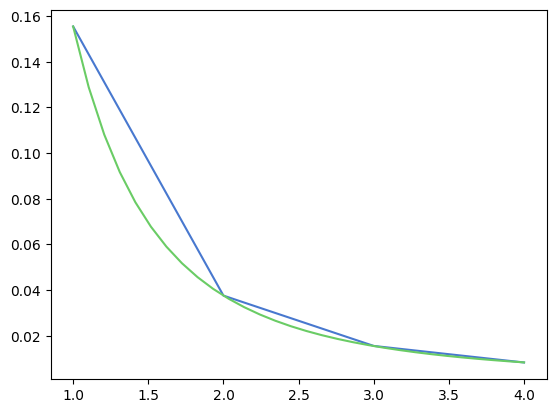

In [132]:
a = np.array([0.15547272, 0.03760767, 0.015572, 0.00832397])
betas = [1,2,3,4]

def BKT(x, c, b, a_c):
    return c*np.exp( -b*abs(x-a_c)**(-1/2) )

p, pcov = curve_fit(BKT, betas, a)
print(p)
print(pcov)
plt.plot(betas, a)
plt.plot(np.linspace(1,4, 30), BKT(np.linspace(1,4, 30), *p))

In [94]:
(1/0.68)

1.4705882352941175

[-0.04872091  0.00654849  0.00368473  0.00574338  0.00269281  0.00063526
  0.00151072 -0.00079988 -0.00084521 -0.00137274]
[-0.02745172  0.00519399  0.01133734  0.00776876  0.01003867  0.00382981
  0.001886   -0.00128212 -0.00576439 -0.00897501]
[-2.03861251e-02  4.82290649e-03  1.05218914e-02  8.49938090e-03
  9.02308901e-03  2.33216814e-03  5.61267867e-04 -7.36456060e-05
 -6.81861415e-03 -9.17615625e-03]
[-0.01077429  0.00487577  0.00442024  0.00349345  0.00353898  0.00371047
  0.0026274  -0.00177293 -0.00590152 -0.00436518]


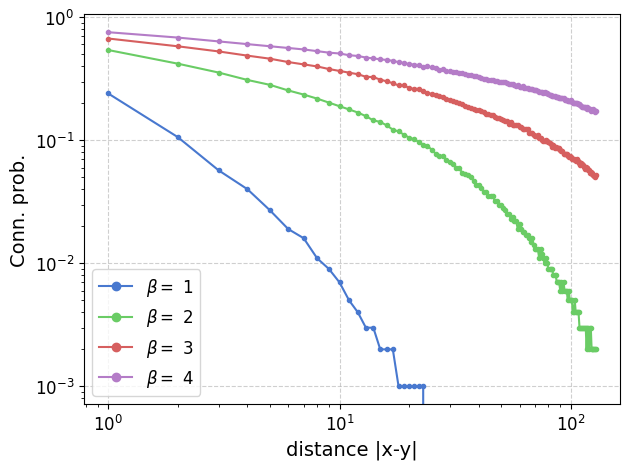

In [121]:
#y = np.reshape(az.summary(idata)['mean'].values, (3, 64)) 


for i in range(0,4):
    x = np.arange(1,129)
    x_fit = np.arange(1, 11)
    plt.plot(x, y[i], '.-', label=r'$\beta = $ ' + f'{betas[i]}')
    # linear fit here
    # linear fit here
    y_fit_data = np.log(y[i][0:10]) 

    # Identify inf and NaN values
    is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)

    # Filter out inf and NaN values
    y_fit_data = y_fit_data[~is_inf_or_nan] 
    p, pcov = curve_fit(lambda x, a, b: a*np.log(x) +b, x_fit[:len(y_fit_data)], np.log(y[i][0:10]))
    y_fit = np.exp(p[0]*np.log(x_fit) + p[1])
    #plt.plot(x_fit, y_fit, label='fit')
    print(y[i][0:10] - y_fit)
plt.yscale('log')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel('Conn. prob.', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_loglog.pdf')

### N = 3

C:\Users\lollo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


-1.8187930798693412 +/ 0.12087126171821179
-0.11602899692773283 +/ 0.0033927996245663294
-0.05596984449111386 +/ 0.0008986126700308185
-0.03310002550090404 +/ 0.0006871848671076264


C:\Users\lollo\AppData\Local\Temp\ipykernel_14952\2053118850.py:9: RuntimeWarning: divide by zero encountered in log
  y_fit_data = np.log(y[i][0:64])


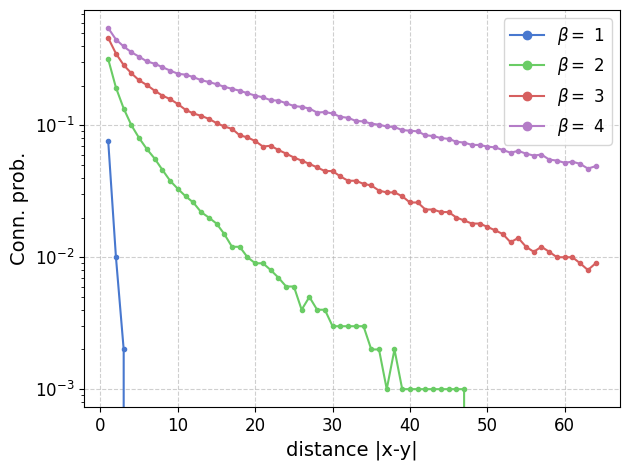

In [149]:
y = np.reshape(az.summary(idata)['mean'].values, (4, 64)) 

for i in range(0,4):
    x = np.arange(1,65)
    x_fit = np.arange(1,65)
    plt.plot(x, y[i], '.-', label=r'$\beta = $ ' + f'{betas[i]}')
    
    # linear fit here
    y_fit_data = np.log(y[i][0:64]) 

    # Identify inf and NaN values
    is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)

    # Filter out inf and NaN values
    y_fit_data = y_fit_data[~is_inf_or_nan] 
    
    p, pcov = curve_fit(lambda x, a, b: a*x +b, x_fit[:len(y_fit_data)], y_fit_data)
    print(f'{p[0]} +/ {np.sqrt(pcov[0,0])}')
    #plt.plot(x_fit[:len(y_fit_data)], np.exp(p[0]*x_fit[:len(y_fit_data)] + p[1]), label='fit')
    
plt.yscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel('Conn. prob.', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
#plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\N3_log.pdf')

C:\Users\lollo\AppData\Local\Temp\ipykernel_14952\2834192134.py:10: RuntimeWarning: divide by zero encountered in log
  y_fit_data = np.log(y[i][0:10])


[-5.03968132e-03  1.59674331e-03 -2.32020779e-04 -8.71359831e-04
 -4.20087518e-04 -2.31445179e-04 -1.39816484e-04 -9.03540119e-05
 -6.14750290e-05 -4.35601817e-05]
[-0.04816839  0.00885746  0.01062648  0.0071429   0.0055108   0.00378675
  0.00257347 -0.00082482 -0.00368221 -0.00456248]
[-0.02461374  0.00856873  0.00747788  0.00694955  0.00350663  0.00536341
  0.0010133  -0.0021816  -0.00240605 -0.00713831]
[-0.01843294  0.00243493  0.00937657  0.00784662  0.00674866  0.00048327
  0.0042286   0.00020822 -0.00482806 -0.00939052]


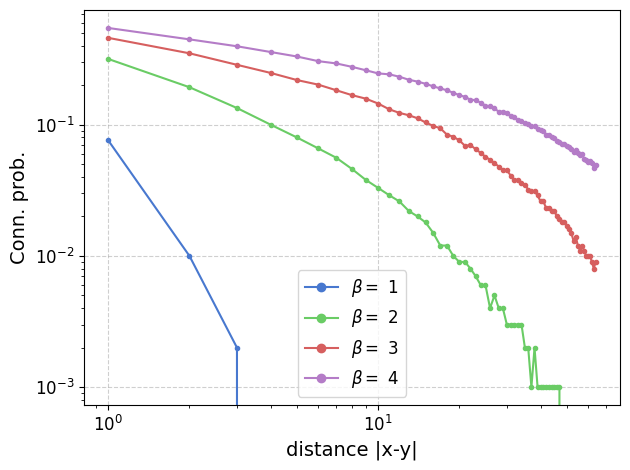

In [145]:
#y = np.reshape(az.summary(idata)['mean'].values, (3, 64)) 


for i in range(0,4):
    x = np.arange(1,65)
    x_fit = np.arange(1, 11)
    plt.plot(x, y[i], '.-', label=r'$\beta = $ ' + f'{betas[i]}')
    
    # linear fit here
    y_fit_data = np.log(y[i][0:10]) 

    # Identify inf and NaN values
    is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)

    # Filter out inf and NaN values
    y_fit_data = y_fit_data[~is_inf_or_nan] 
    
    p, pcov = curve_fit(lambda x, a, b: a*np.log(x) +b, x_fit[:len(y_fit_data)], y_fit_data)
    y_fit = np.exp(p[0]*np.log(x_fit) + p[1])
    #plt.plot(x_fit, y_fit, label='fit')
    print(y[i][0:10] - y_fit)
plt.yscale('log')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel('Conn. prob.', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\N3_loglog.pdf')

# Fraction of sites in a loop of length > K

- sort loops according to length $(l_1, l_2, ... l_n)$
- find number of vertices in each loop $v(l)$ 
- for $K \in [2, max]$, find all loops with |l| >= K, and add the vertices normalized:
$$
\nu(K) := \frac{1}{L^2} \sum_{|l| \geq K} v(l)
$$

this sum is an upper bound on the empirical prob that a vertex is in a loop of length >= K (the visits are not disjoint!)

This quantity shows a BKT PT around $\beta \approx 1.1$, we follow the general theory to estimate the $p(\beta)$, the power law decay above $\beta_c$, and $r(\beta)$ the exponential decay rate below $\beta_c$. 


In [55]:
m = StateSpace(2, 128, 1.1)
m.step(10_000_000)

  0%|          | 0/10000000 [00:00<?, ?it/s]

In [57]:
def sort_lengths_and_visits(lengths, visits):
        # Pair each length with its corresponding visits
        paired_lengths_visits = list(zip(lengths, visits))
        
        # Sort the list of tuples by length
        sorted_pairs = sorted(paired_lengths_visits, key=lambda x: x[0])
        
        # Separate the sorted lengths and the corresponding sorted visits
        sorted_lengths = [pair[0] for pair in sorted_pairs]
        sorted_visits = [pair[1] for pair in sorted_pairs]
        
        return sorted_lengths, sorted_visits

def nu(max_K=1_000):  # manyally adjust!
    _, lengths, visits = m.loop_builder()
    # Sort lengths and apply the permutation to visits
    sorted_lengths, sorted_visits = sort_lengths_and_visits(lengths[0], visits[0])
    
    
    # Step 3: Calculate the sum of visits for each K from 2 to the max loop length
    #max_length = sorted_lengths[-1] if sorted_lengths else 0
    cumulative_visits = []
    #if max_K == None:
    #    max_K = max_length
    Ks = [ 2*np.ceil((max_K/2)**gamma) for gamma in np.linspace(1e-2, 1, 100)  ]
    for K in Ks:
        # Find all visits where the corresponding length >= K
        visits_ge_K = [visit for length, visit in zip(sorted_lengths, sorted_visits) if length >= K]
        
        # Sum the visits
        sum_visits = sum(visits_ge_K)
        
        # Store the result
        cumulative_visits.append(sum_visits)
    
    return Ks, np.array(cumulative_visits) /  m.grid_size**2


Ks, result = nu()
print(result)

[0.45513916 0.45513916 0.45513916 0.45513916 0.45513916 0.45513916
 0.45513916 0.45513916 0.45513916 0.45513916 0.45513916 0.39190674
 0.39190674 0.39190674 0.39190674 0.39190674 0.39190674 0.35394287
 0.35394287 0.35394287 0.35394287 0.35394287 0.32226562 0.32226562
 0.32226562 0.29779053 0.29779053 0.29779053 0.28088379 0.28088379
 0.28088379 0.26184082 0.26184082 0.24957275 0.24957275 0.2388916
 0.2388916  0.23046875 0.21612549 0.20709229 0.20709229 0.20123291
 0.19061279 0.1864624  0.18377686 0.17370605 0.16619873 0.16271973
 0.15808105 0.15283203 0.15112305 0.14703369 0.1449585  0.14025879
 0.13293457 0.13018799 0.12023926 0.11730957 0.1137085  0.11090088
 0.10797119 0.10443115 0.10443115 0.10046387 0.08404541 0.07049561
 0.07049561 0.07049561 0.06408691 0.05200195 0.04553223 0.03833008
 0.03015137 0.02215576 0.02215576 0.01373291 0.01373291 0.01373291
 0.01373291 0.01373291 0.01373291 0.01373291 0.01373291 0.
 0.         0.         0.         0.         0.         0.
 0.         

188


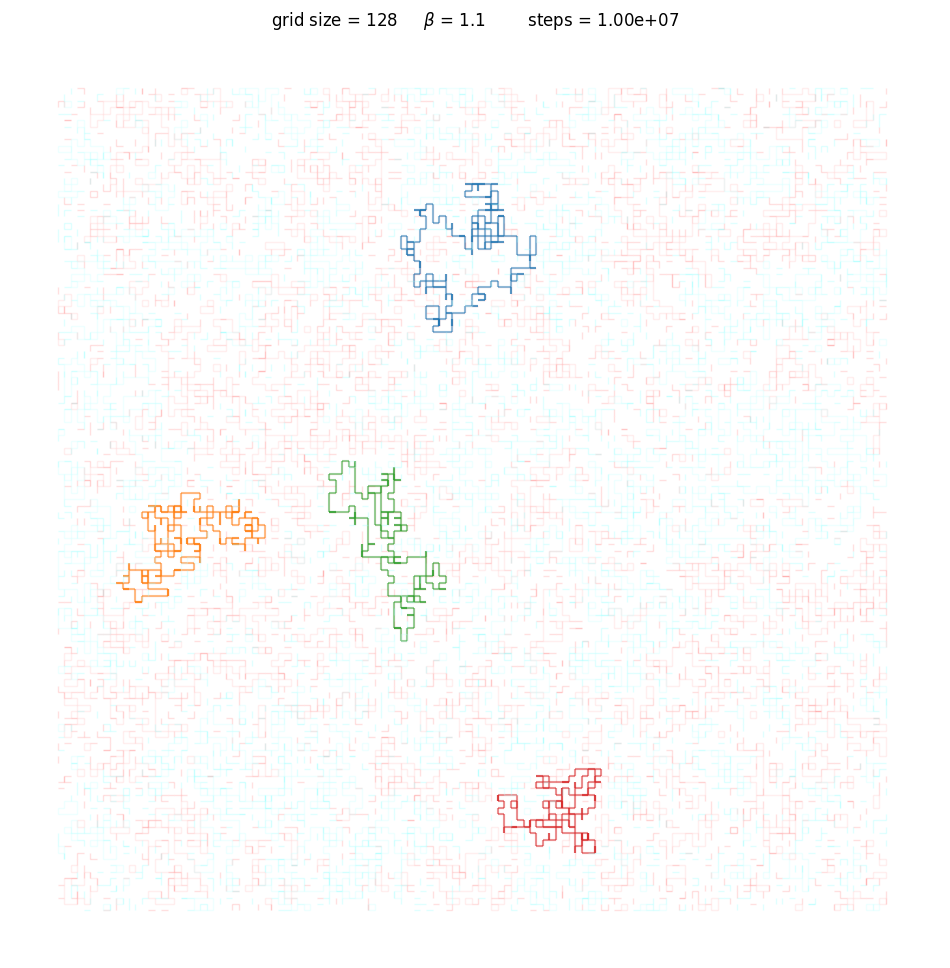

In [64]:
#plt.style.use('dark_background')
plt.style.use('default')
plt.style.use('seaborn-v0_8-muted')



def k_greatest_indices(lst, k):
    # Convert list to NumPy array
    arr = np.array(lst)
    
    # Get the indices that would sort the array
    sorted_indices = np.argsort(arr)
    
    # Select the last k indices (the k largest elements)
    k_largest_indices = sorted_indices[-k:]
    
    # Since argsort returns indices in ascending order, reverse them to get the largest first
    k_largest_indices = k_largest_indices[::-1]
    
    return k_largest_indices

top_idx_0 = k_greatest_indices(lengths[0], k=4)

print(np.max(visits[0]))

top_loops = [[loops[0][i] for i in top_idx_0], [], []] # [loops[1][i] for i in top_idx_1], [loops[2][i] for i in top_idx_2] ]


m.plot_loop_overlap(top_loops, alpha_links=0.3, alpha_loop=0.5, linewidth=1.5)

In [3]:
def read_nu_data(file_name):
    
    with open(file_name, 'r') as file:
        data_raw = json.load(file)
    #max_distance = data_raw['params']['grid_size'] // 2
    data = {
    'nu': np.array(data_raw['results'])
    }

    print(np.shape(data['nu']))
    coords = {
        'beta': data_raw['params']['betas'],
        'K': range(100), #[ 2*np.ceil((1000/2)**gamma) for gamma in np.linspace(1e-2, 1, 100)  ]
    }

    dims = {
        'nu': ["beta", "K"]
    }
    idata = az.convert_to_inference_data(data, coords=coords, dims=dims)
    return idata

In [ ]:
nu_data = read_nu_data(r'data\corr\XY_nu_128_2024-06-14_02_50_52.json')
y = np.reshape(az.summary(nu_data)['mean'].values, (4, 100)) 

nu_data_12 = read_nu_data(r'data\\corr\\XY_nu_128_2024-06-14_11_38_04.json')
y_12 = np.reshape(az.summary(nu_data_12)['mean'].values, (1, 100)) 

nu_data_1314 = read_nu_data(r'data\\corr\\XY_nu_128_2024-06-14_13_02_58.json')
y_1314 = np.reshape(az.summary(nu_data_1314)['mean'].values, (2, 100))

nu_data_1518 = read_nu_data(r'data\\corr\\XY_nu_128_2024-06-14_16_13_43.json')
y_1518 = np.reshape(az.summary(nu_data_1518)['mean'].values, (4, 100))
# merge data 
y_merged = np.vstack((y, y_12, y_1314, y_1518))

nu_data_hb = read_nu_data(r'data\\corr\\XY_nu_128_2024-06-14_21_55_49.json')
y_hb = np.reshape(az.summary(nu_data_hb)['mean'].values, (5, 100))


In [13]:
1/np.arange(0.8, 0.3, -0.05)

array([1.25      , 1.33333333, 1.42857143, 1.53846154, 1.66666667,
       1.81818182, 2.        , 2.22222222, 2.5       , 2.85714286])

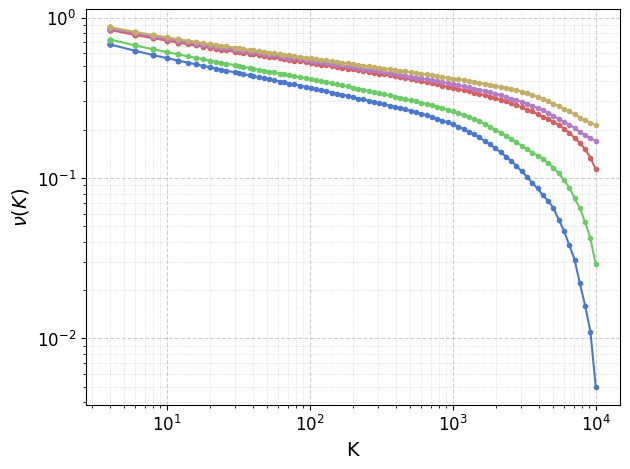

In [7]:
betas = [1.6, 1.8, 2.0 , 2.2, 2.4]   #nu_data['posterior'].coords['beta'].values
x = [ 2*np.ceil(5000**gamma) for gamma in np.linspace(1e-2, 1, 100)  ]
for i in range(len(betas)):
    plt.plot(x, y_hb[i], label=r'$\beta = $' + f'{betas[i]}', marker='.')
   
plt.yscale('log')
plt.xscale('log')
plt.xlabel('K', fontsize=14)
plt.ylabel(r'$\nu(K)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=10, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()

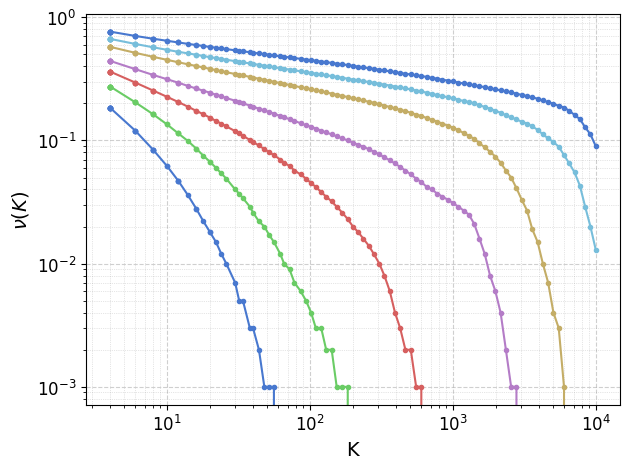

In [24]:
betas = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]   #nu_data['posterior'].coords['beta'].values
x = [ 2*np.ceil(5000**gamma) for gamma in np.linspace(1e-2, 1, 100)  ]
for i in range(len(betas)):
    if betas[i] not in [1.2, 1.6, 1.7, 1.5] :
        plt.plot(x, y_merged[i], label=r'$\beta = $' + f'{betas[i]}', marker='.')
   
plt.yscale('log')
plt.xscale('log')
plt.xlabel('K', fontsize=14)
plt.ylabel(r'$\nu(K)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=10, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
#plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_nu_loglog.pdf')

(8, 250, 10, 100)
0.2481819336845967 +/- 0.0011489084886881571
0.2132528694001201 +/- 0.0015710227343578996
0.20043438787773316 +/- 0.0007299790803639645
0.1829755789495751 +/- 0.0010218473029872512
0.15885835785309 +/- 0.0006584994786157051
0.13692327248291292 +/- 0.0006300649013548048
0.12124443865831164 +/- 0.0006373965111044539
0.1056378196754955 +/- 0.0006844696887365013
0.09627343188322514 +/- 0.0005882671824361081
0.09168129272647042 +/- 0.0006472114019741882


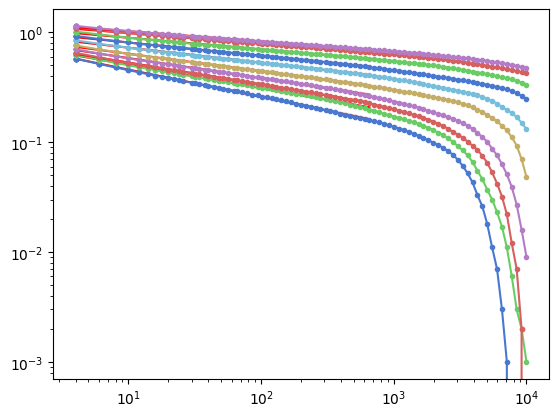

In [4]:
# linear fit to get power law coeff
idata_hb = read_nu_data(r'data\\corr\\XY_nu_hb_128_2024-06-18_00_24_17.json')
y_hb = np.reshape(az.summary(idata_hb, kind='stats')['mean'].values, (10, 100))
x = [ 2*np.ceil(5000**gamma) for gamma in np.linspace(1e-2, 1, 100)  ]
p_beta = []
p_beta_sigma = []
beta_fit = []
betas = idata_hb['posterior'].coords['beta'].values
for i in range(10):
    beta_fit.append(betas[i])
    # Remove duplicates while preserving the order
    _, idx = np.unique(y_hb[i], return_index=True)
    y_fit_data = np.log(y_hb[i][np.sort(idx)][:50])

    x_fit = np.unique(x, return_index=False)[:50]
 

    # linear fit here
    #y_fit_data = np.log(y_hb[i][:50]) 
    # Identify inf and NaN values
    is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)
    # Filter out inf and NaN values
    y_fit_data = y_fit_data[~is_inf_or_nan] 
    
    p, pcov = curve_fit(lambda x, a, b: -a*np.log(x) +b, x_fit[:len(y_fit_data)], y_fit_data)
    p_beta.append(p[0])
    p_beta_sigma.append(np.sqrt(pcov[0,0]))
    print(f'{p[0]} +/- {np.sqrt(pcov[0,0])}' )
    
    y_fit = np.exp(-p[0]*np.log(x_fit) + p[1])
    plt.plot(x_fit, y_fit, label='fit' + f'{betas[i]}', c='r')
    plt.plot(x, y_hb[i], label=r'$\beta = $' + f'{betas[i]}', marker='.')
    
plt.yscale('log')
plt.xscale('log')
#plt.legend()

In [255]:
1/ ((0.86707*(1/0.0541**2) + 0.8801424085632228*(1/0.10169618618794518**2) )/ ( 1/0.0541**2 + 1/0.10169618618794518**2 ))

1.1494867739423023

In [7]:
1/(np.pi)

0.3183098861837907

[ 0.33035287 -0.03644058]
0.86707  +/- 0.05410


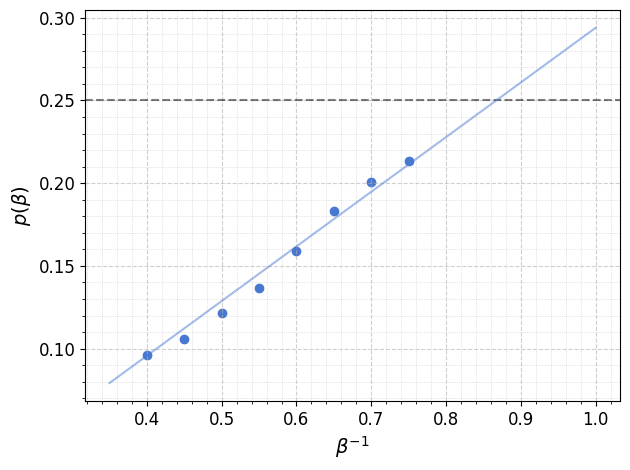

In [5]:
X = 1/np.array(beta_fit[1:])
Y = np.array(p_beta[1:])

plt.scatter(X[:-1], Y[:-1])
p, pcov = curve_fit(lambda x, a, b: a*x + b, X, Y)
plt.axhline(y=0.25,c='black', linestyle='--', alpha=0.5)
plt.plot(np.linspace(0.35, 1.0, 100), p[0]*np.linspace(0.35, 1.0, 100) + p[1], alpha=0.5)
print(p)
T_c = (0.25 - p[1]) / p[0]
T_c_error = np.sqrt( (1/p[0])*pcov[1,1] + ((0.25-p[1])/p[0]**2)**2*pcov[0,0] )
print(f'{T_c:.5f}  +/- {T_c_error:.5f}')


plt.xlabel(r'$\beta^{-1}$', fontsize=14)
plt.ylabel(r'$p(\beta)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=10, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_power.pdf')

# BEAUTIFUL!

In [ ]:
# linear fit to get exp coeff

r_beta = []

for i in range(0, 4):
    x_fit = np.array(x[:30])
    # linear fit here
    y_fit_data = np.log(y_merged[i][:30]) 
    # Identify inf and NaN values
    is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)
    # Filter out inf and NaN values
    y_fit_data = y_fit_data[~is_inf_or_nan] 
    
    p, pcov = curve_fit(lambda x, a, b: -a*x+b, x_fit[:len(y_fit_data)], y_fit_data)
    r_beta.append(p[0])
    print(f'{p[0]} +/- {np.sqrt(pcov[0,0])}' )
    print(x_fit)
    y_fit = np.exp(p[0]*x_fit[:len(y_fit_data)] + p[1])
    plt.plot(x_fit[:len(y_fit_data)], y_fit, label='fit')
    
plt.yscale('log')


In [7]:
1/0.8

1.25

### High temperature

Here we look for the exponential decay rate in the high temperature region above $T_c$:
$$
\nu(K) \sim e^{-r(\beta)K}, \qquad r(\beta) = c e^{-b/|\beta^{-1}-\beta_c^{-1}|^{1/2}}
$$

In [22]:
1/np.arange(2, 1.2, -0.1)

array([0.5       , 0.52631579, 0.55555556, 0.58823529, 0.625     ,
       0.66666667, 0.71428571, 0.76923077])

(8, 250, 8, 100)
(8, 250, 3, 100)
0.5800590256353397 +/- 0.007262525630575751
0.45994627450421044 +/- 0.02110478850246968
0.4767080746660435 +/- 0.010015513399014905
0.3945852968568946 +/- 0.015490126961988968
0.2986909127728852 +/- 0.010387059148845496
0.2704287442842963 +/- 0.007661884652041831
0.2035711043729358 +/- 0.005313255914457953
0.13857452471108433 +/- 0.0026617542926433433
0.07985931260554258 +/- 0.0010373283717574093
0.04246118269250032 +/- 0.000776428018429129
0.01837494975645745 +/- 0.000534982257309166


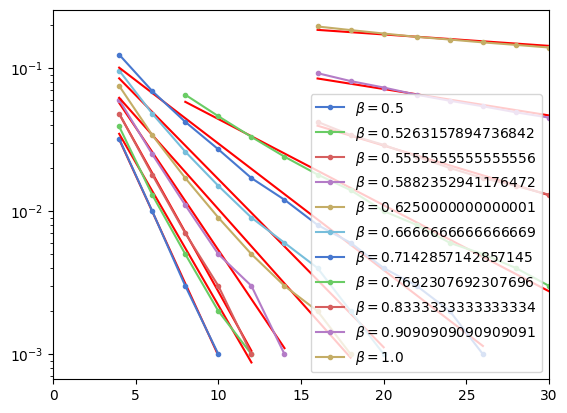

In [212]:
idata_lb = read_nu_data(r'data\\corr\\XY_nu_lb_128_2024-06-18_15_25_26.json')
idata_lb_2 = read_nu_data(r'data\\corr\\XY_nu_lb_128_2024-06-18_18_13_28.json')
y_lb_2 = np.reshape(az.summary(idata_lb_2, kind='stats')['mean'].values, (3, 100))
y_lb_1 = np.reshape(az.summary(idata_lb, kind='stats')['mean'].values, (8, 100))
x = [ 2*np.ceil(50**gamma) for gamma in np.linspace(1e-2, 1, 100)  ]

y_lb = np.vstack( (y_lb_1, y_lb_2) ) #maybe reverse!

r_beta_sigma = []
r_beta = []
beta_fit = []
betas = np.array(list(idata_lb['posterior'].coords['beta'].values) + list(idata_lb_2['posterior'].coords['beta'].values))

max_x = [
    4, 5, 5, 6,
    8, 9, 12, 15, 
    20, 25, 25
]

min_x = [
    0, 0, 0, 0,
    0, 0, 0, 2, 
    6, 6, 6
]

for i in range(len(y_lb)):
     

    # Remove duplicates while preserving the order
    _, idx = np.unique(y_lb[i], return_index=True)
    y_fit_data = y_lb[i][np.sort(idx)][min_x[i]:max_x[i]]
    x_fit = np.unique(x, return_index=False)[min_x[i]:max_x[i]]

    # Identify inf and NaN values
    #is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)
    # Filter out inf and NaN values
    #y_fit_data = y_fit_data[~is_inf_or_nan] 
    p, pcov = curve_fit(lambda x, a, b: -a*x +b, x_fit, np.log(y_fit_data))
    
    #p, pcov = curve_fit(lambda x, a, b: a*np.exp(-b*x), x_fit, y_fit_data)
    
    r_beta.append(p[0])
    r_beta_sigma.append(np.sqrt(pcov[0,0]))
    
    print(f'{p[0]} +/- {np.sqrt(pcov[0,0])}' )
   
    y_fit = np.exp(-p[0]*x_fit + p[1])
    plt.plot(x_fit, y_fit, c='r')
    plt.plot(x_fit[:max_x[i]], y_fit_data[:max_x[i]], label=r'$\beta = $' + f'{betas[i]}', marker='.')

plt.xlim((0,30)) 
plt.yscale('log')
plt.legend()

C:\Users\lollo\AppData\Local\Temp\ipykernel_17632\681758069.py:2: RuntimeWarning: divide by zero encountered in divide
  return c*np.exp(-b/np.sqrt(np.abs(x-a)))


0.8801424085632228 +/- 0.10169618618794518


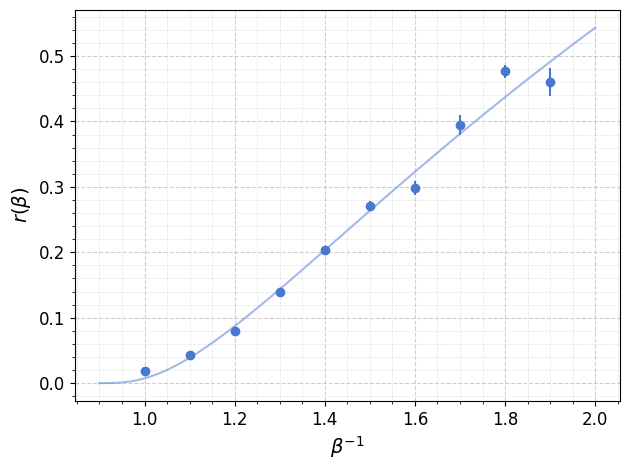

In [217]:
def BKT(x, a, b, c):
    return c*np.exp(-b/np.sqrt(np.abs(x-a)))

p, pcov = curve_fit(BKT, 1/betas[1:], r_beta[1:])
print(f'{p[0]} +/- {np.sqrt(pcov[0,0])}')

plt.errorbar(x=1/betas[1:], y=r_beta[1:], yerr=r_beta_sigma[1:], fmt=' ', marker='o')
x = np.linspace(0.9, 2, 100)
plt.plot(x, BKT(x, *p), c='C0', alpha=0.5)
#plt.plot(x, BKT(x, 0.89, p_old[1], p_old[2]), c='C1', alpha=0.5)
plt.xlabel(r'$\beta^{-1}$', fontsize=14)
plt.ylabel(r'$r(\beta)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=10, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_exp.pdf')

In [211]:
p_old = p

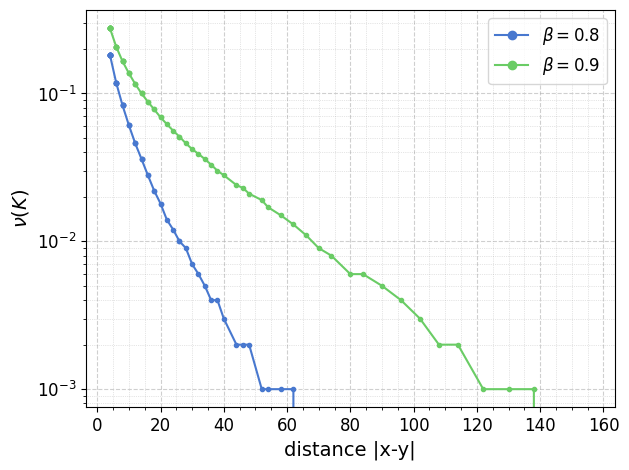

In [106]:
for i in range(2):
    plt.plot(x[:70], y[i][:70], label=r'$\beta = $' + f'{betas[i]}', marker='.')


plt.yscale('log')
#plt.xscale('log')
plt.xlabel('distance |x-y|', fontsize=14)
plt.ylabel(r'$\nu(K)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
#plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\XY_loglog_long.pdf')

### N = 3

(8, 200, 7, 100)


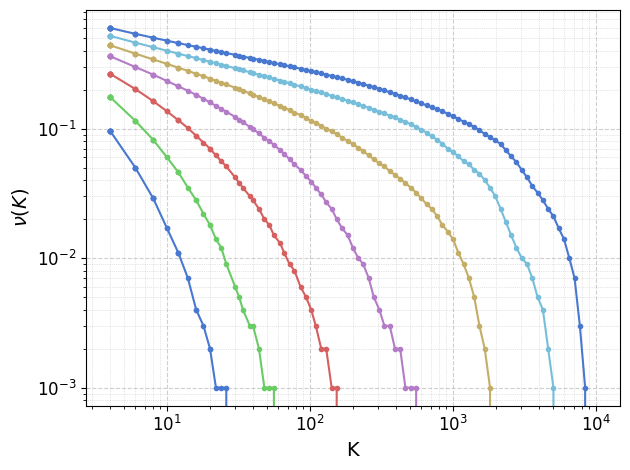

In [218]:
data_3 = read_nu_data(r'data\\corr\\3_nu_128_2024-06-15_05_39_02.json')
y3 = np.reshape(az.summary(data_3, kind='stats')['mean'].values, (7, 100))
x = [ 2*np.ceil(5000**gamma) for gamma in np.linspace(1e-2, 1, 100)  ]
for i in range(7):
    plt.plot(x, y3[i], marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('K', fontsize=14)
plt.ylabel(r'$\nu(K)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=10, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\3_nu_loglog.pdf')

0.24165886152299815 +/- 0.006110835714192525
0.1359138722790667 +/- 0.004973196691631952
0.07764059670876888 +/- 0.00399325890344597
0.04640312918821937 +/- 0.0031273686020226415
0.03292602703948322 +/- 0.002615238380370787
0.025253623966257854 +/- 0.002212425626548579
0.020996677510386808 +/- 0.0019467937872574717


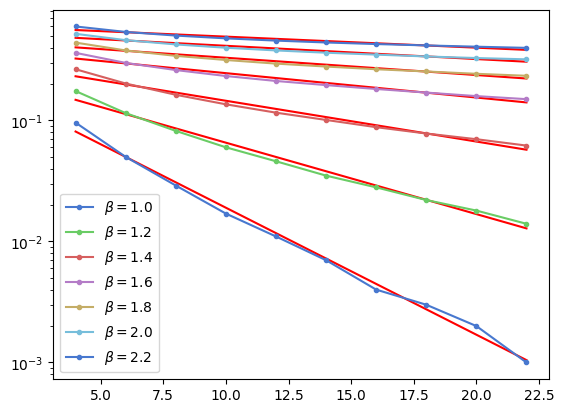

In [226]:
# compute exp decay rates 

r3_beta_sigma = []
r3_beta = []

betas = data_3['posterior'].coords['beta'].values

max_x = [
  10, 10, 10, 10,
  10, 10, 10
]

min_x = [
  0, 0, 0, 0,
  0, 0, 0
]

for i in range(len(y3)):

    # Remove duplicates while preserving the order
    _, idx = np.unique(y3[i], return_index=True)
    y_fit_data = y3[i][np.sort(idx)][min_x[i]:max_x[i]]
    x_fit = np.unique(x, return_index=False)[min_x[i]:max_x[i]]

    # Identify inf and NaN values
    #is_inf_or_nan = np.isinf(y_fit_data) | np.isnan(y_fit_data)
    # Filter out inf and NaN values
    #y_fit_data = y_fit_data[~is_inf_or_nan] 
    p, pcov = curve_fit(lambda x, a, b: -a*x +b, x_fit, np.log(y_fit_data))
    
    #p, pcov = curve_fit(lambda x, a, b: a*np.exp(-b*x), x_fit, y_fit_data)
    
    r3_beta.append(p[0])
    r3_beta_sigma.append(np.sqrt(pcov[0,0]))
    
    print(f'{p[0]} +/- {np.sqrt(pcov[0,0])}' )
   
    y_fit = np.exp(-p[0]*x_fit + p[1])
    plt.plot(x_fit, y_fit, c='r')
    plt.plot(x_fit[:max_x[i]], y_fit_data[:max_x[i]], label=r'$\beta = $' + f'{betas[i]}', marker='.')

 
plt.yscale('log')
plt.legend()

In [223]:
1/betas

array([1.        , 0.83333333, 0.71428571, 0.625     , 0.55555556,
       0.5       , 0.45454545])

[ 0.0075774   3.55236755 -0.01915215]


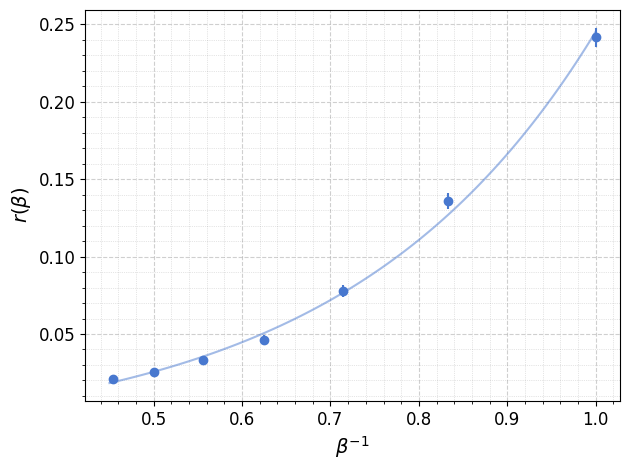

In [251]:
plt.errorbar(x=1/betas, y=r3_beta, yerr=r3_beta_sigma, fmt=' ', marker='o')
x = np.linspace(0.45, 1, 100)


p, pcov = curve_fit(lambda x, a, b, c: a*np.exp(b*x)+c, 1/betas, r3_beta, p0=(0.01, 4, 0), sigma=r3_beta_sigma, absolute_sigma=True)
print(f'{p}')

plt.plot(x, p[0]*np.exp(p[1]*x)+p[2], c='C0', alpha=0.5)
plt.xlabel(r'$\beta^{-1}$', fontsize=14)
plt.ylabel(r'$r(\beta)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=10, markerscale=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.4)
plt.tight_layout()
plt.savefig(r'C:\Users\lollo\Documents\Università\Thesis\Media\conn_prob\3_exp.pdf')

# Hypotesis N = 2 

for $\beta > \beta_c$ uno dei colori domina sull'altro

In [23]:
#m = StateSpace(2, 32, 2)

def diff():
    ml = m.mean_links()
    return np.abs(  ml[0] - ml[1]  ) / (ml[0] + ml[1])

obs = {
    'diff': diff,
    'links': m.mean_links
}

m.step(100_000_000, 100_000, observables=obs) 

  0%|          | 0/100000000 [00:00<?, ?it/s]

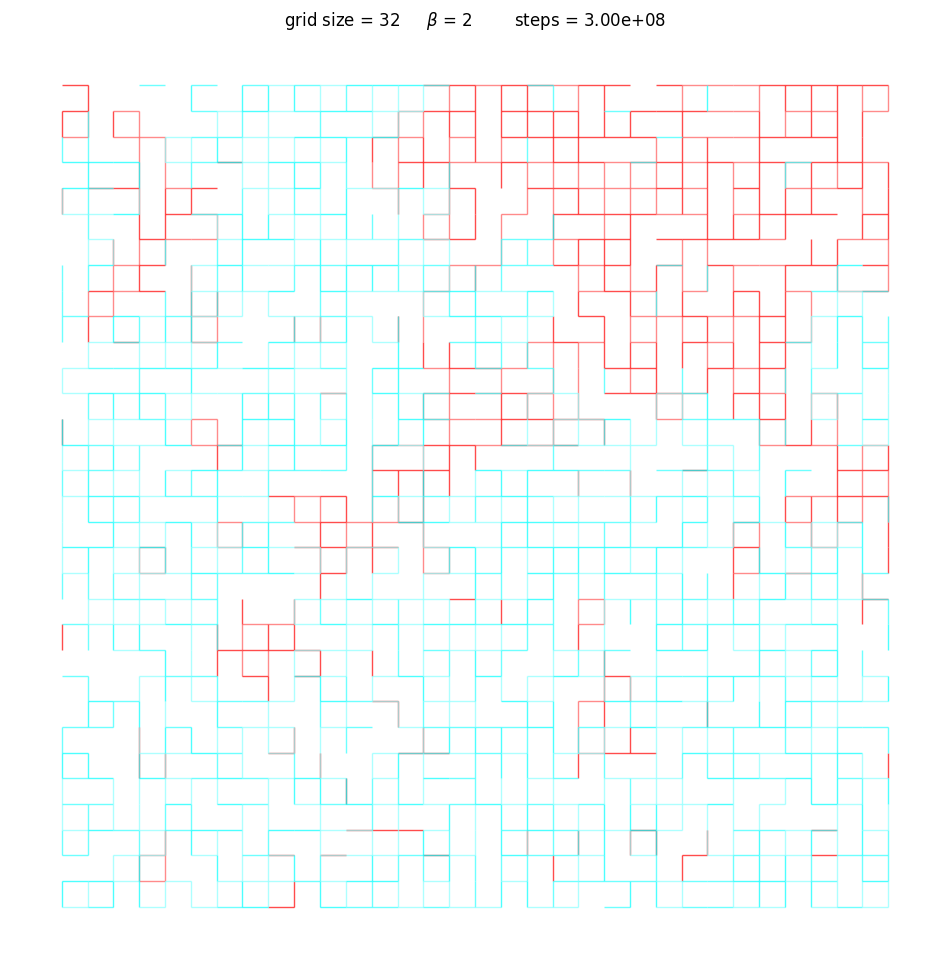

mean number of links: [0.55126953 1.17626953]
max number of links: [8 8]
mean local time: 3.6243496357960456


ValueError: too many values to unpack (expected 2)

In [24]:
m.plot_overlap()
m.summary()

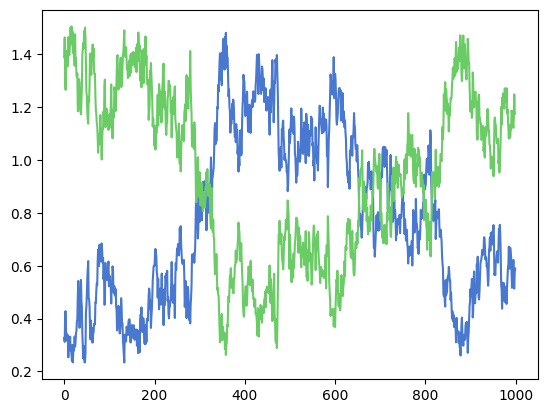

In [28]:
#plt.plot(m.data['diff'])
plt.plot(m.data['links'])

In [26]:
np.mean(m.data['diff'][1:])

0.37707039026625755